<a href="https://colab.research.google.com/github/JHyunjun/ARIMA_PY/blob/main/260122_cmsGAN_SOTA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#### Alpha, Beta 8 유지하고, 전압 CCL 추가 (CCV)

import os
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, LeakyReLU, Conv1D, Input, Concatenate, Flatten, LSTM, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

tf.keras.mixed_precision.set_global_policy('mixed_float16')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


In [ ]:
def MinMaxScaler(data, data_min, data_max):
    return (data - data_min) / (data_max - data_min + 1e-7)

# Data paths
paths = [
    r"C:\Users\user\Desktop\JANG\code\AI\asd1_1.txt",
    r"C:\Users\user\Desktop\JANG\code\AI\asd1_2.txt",
    r"C:\Users\user\Desktop\JANG\code\AI\asd1_3.txt",
    r"C:\Users\user\Desktop\JANG\code\AI\asd1_4.txt",
    r"C:\Users\user\Desktop\JANG\code\AI\asd1_5.txt",
]

raw_dfs = [pd.read_csv(p, delimiter=",") for p in paths]
cols = ["Current", "SOC", "Voltage"]
train_dfs = [df.iloc[:, [0, 2, 4]].copy() for df in raw_dfs]
for df in train_dfs:
    df.columns = cols

def quantize_soc(soc):
    soc_int = int(soc)
    if soc_int == 100:
        return 100
    if soc_int % 1 != 0:
        return soc_int - 1
    return soc_int

for df in train_dfs:
    df["SOC"] = df["SOC"].apply(quantize_soc)

for df in train_dfs:
    df["DI"] = df["Current"].diff().fillna(0)

final_cols = ["Current", "SOC", "Voltage", "DI"]
train_dfs = [df[final_cols] for df in train_dfs]

combined = pd.concat(train_dfs, ignore_index=True)
data_min = combined.min().values
data_max = combined.max().values

scaled = [MinMaxScaler(df.values, data_min, data_max) for df in train_dfs]

window_size = 120
overlap_factor = 0.9

def create_sequences(data, window_size, overlap):
    stride = int(window_size * (1 - overlap))
    sequences = []
    for i in range(0, len(data) - window_size + 1, stride):
        sequences.append(data[i:i + window_size])
    return np.array(sequences)

seqs = [create_sequences(s, window_size, overlap_factor) for s in scaled]
final_sequences = np.concatenate(seqs[:3], axis=0)
all_sequences = final_sequences
train_sequences = all_sequences

print("Final sequences shape:", train_sequences.shape)


Final sequences shape: (5267, 120, 4)


In [ ]:
# Denorm helper
def denorm_feature(arr, feature_index):
    return arr * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

# Teacher training (fresh) with Huber loss
teacher_X = train_sequences[..., [0, 1, 3]]  # Current, SOC, DI
teacher_Y = train_sequences[..., 2:3]        # Voltage


In [ ]:
def build_teacher_lstm(input_shape):
    inp = Input(shape=input_shape, dtype='float32')
    x = LSTM(128, return_sequences=True)(inp)
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64, return_sequences=True)(x)
    out = TimeDistributed(Dense(1, activation='sigmoid'))(x)
    return Model(inp, out, name="Teacher_LSTM")


def lr_schedule(epoch, lr):
    if epoch > 0 and epoch % 20 == 0:
        return lr * 0.9
    return lr

teacher_lstm = build_teacher_lstm((window_size, 3))
teacher_lstm.compile(optimizer=Adam(learning_rate=2e-4), loss=tf.keras.losses.Huber())

history_teacher = teacher_lstm.fit(
    teacher_X,
    teacher_Y,
    epochs=3000,
    batch_size=64,
    callbacks=[LearningRateScheduler(lr_schedule, verbose=0)],
    verbose=1,
)

teacher_lstm.save("260122_teacher_lstm_fresh_120.h5")
print("Saved 260122_teacher_lstm_fresh_120.h5")


Epoch 1/3000
83/83 [==============================] - 12s 37ms/step - loss: 0.0093 - lr: 2.0000e-04
Epoch 2/3000
83/83 [==============================] - 3s 37ms/step - loss: 0.0030 - lr: 2.0000e-04
Epoch 3/3000
83/83 [==============================] - 3s 38ms/step - loss: 0.0022 - lr: 2.0000e-04
Epoch 4/3000
83/83 [==============================] - 3s 39ms/step - loss: 0.0019 - lr: 2.0000e-04
Epoch 5/3000
83/83 [==============================] - 3s 36ms/step - loss: 0.0016 - lr: 2.0000e-04
Epoch 6/3000
83/83 [==============================] - 3s 36ms/step - loss: 0.0014 - lr: 2.0000e-04
Epoch 7/3000
83/83 [==============================] - 3s 38ms/step - loss: 0.0013 - lr: 2.0000e-04
Epoch 8/3000
83/83 [==============================] - 3s 37ms/step - loss: 0.0012 - lr: 2.0000e-04
Epoch 9/3000
83/83 [==============================] - 3s 38ms/step - loss: 0.0011 - lr: 2.0000e-04
Epoch 10/3000
83/83 [==============================] - 3s 37ms/step - loss: 0.0010 - lr: 2.0000e-04
Epoch 11

7/7 [==============================] - 1s 19ms/step
Teacher MAE: 1.4148500000000004
Teacher RMSE: 1.5612214769211958


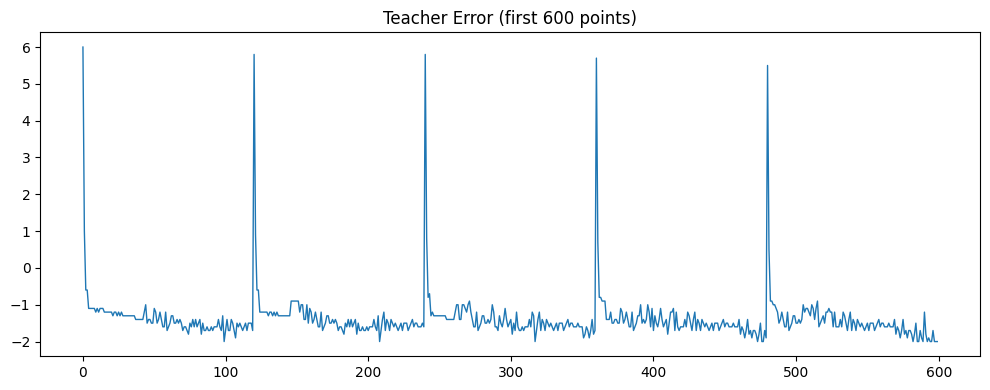

In [ ]:
# Teacher quick error check

teacher_lstm = tf.keras.models.load_model(
    "260122_teacher_lstm_fresh_120.h5",
    custom_objects={"Huber": tf.keras.losses.Huber}
)

pred = teacher_lstm.predict(teacher_X[:200])
true = teacher_Y[:200]
pred_dn = denorm_feature(pred[..., 0], 2)
true_dn = denorm_feature(true[..., 0], 2)
err = true_dn - pred_dn
print('Teacher MAE:', float(np.mean(np.abs(err))))
print('Teacher RMSE:', float(np.sqrt(np.mean(err**2))))
plt.figure(figsize=(10,4))
plt.plot(err.flatten()[:600], linewidth=1)
plt.title('Teacher Error (first 600 points)')
plt.tight_layout()
plt.show()


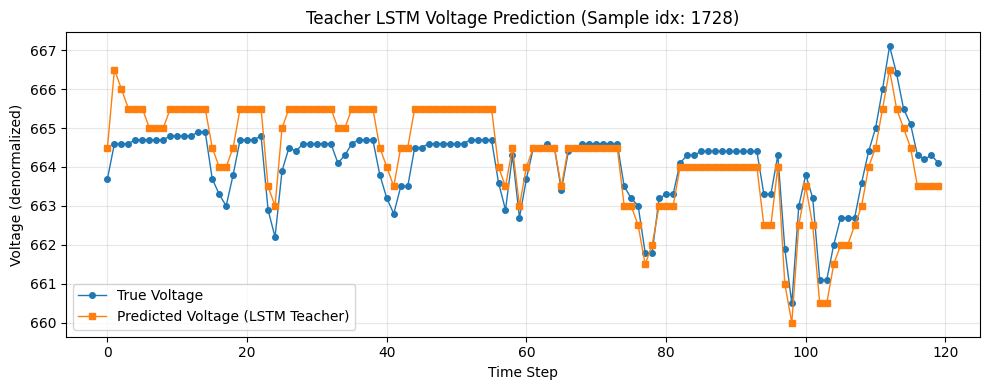

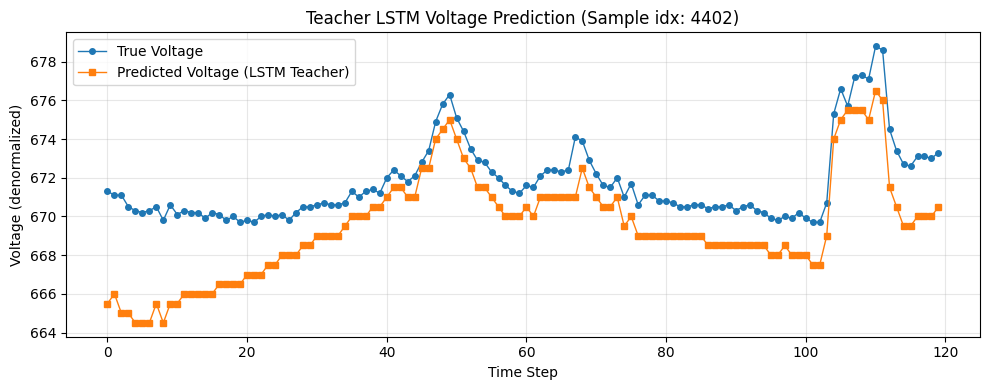

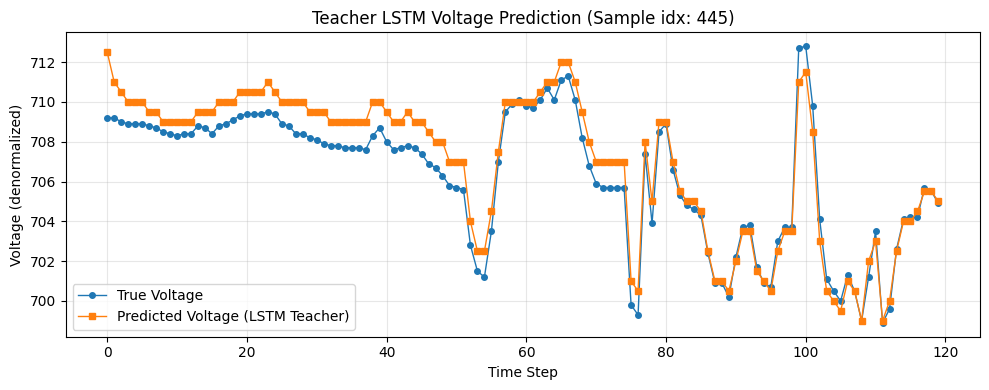

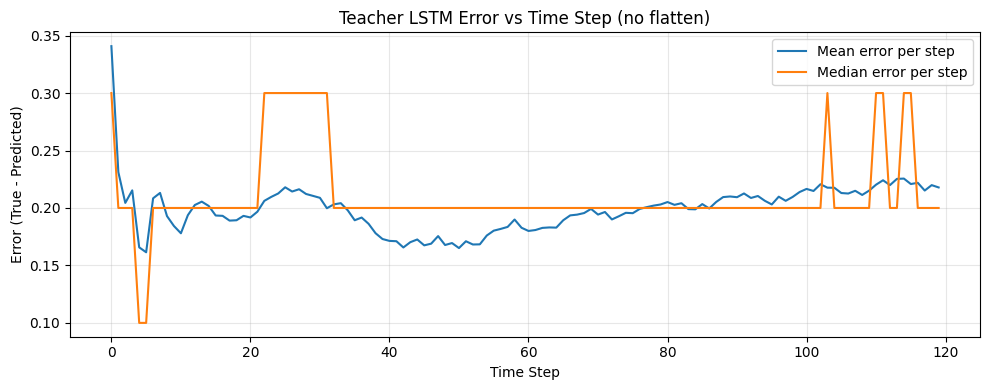

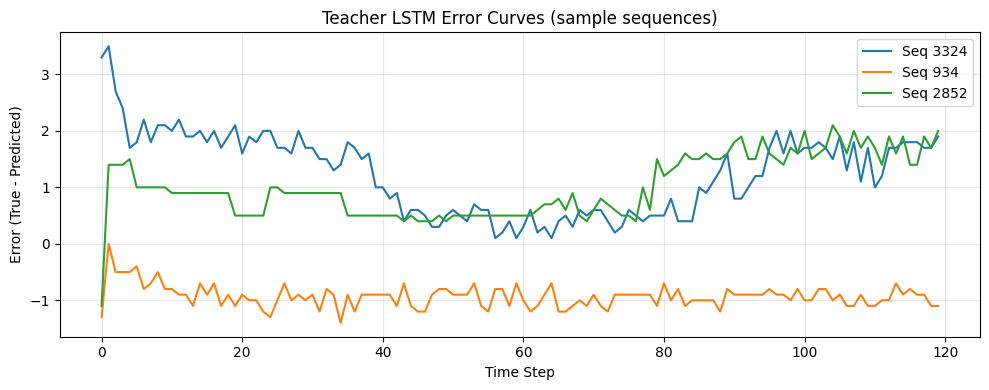

In [ ]:
# =========================
# Plotting (LSTM Teacher only)
# =========================

def denorm_vector(vec, feature_index, data_min, data_max):
    return vec * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]


# (1) Random samples: True vs Pred (LSTM)
num_samples = teacher_X.shape[0]
random_indices = np.random.choice(num_samples, size=3, replace=False)

for idx in random_indices:
    sample_input = teacher_X[idx:idx+1]   # (1, T, 3)
    sample_true  = teacher_Y[idx:idx+1]   # (1, T, 1)

    pred_lstm = teacher_lstm.predict(sample_input, verbose=0)  # (1, T, 1)

    true_flat = sample_true.reshape(-1)
    pred_flat = pred_lstm.reshape(-1)

    # Voltage feature index = 2 (train_sequences ??)
    true_denorm = denorm_vector(true_flat, 2, data_min, data_max)
    pred_denorm = denorm_vector(pred_flat, 2, data_min, data_max)

    plt.figure(figsize=(10, 4))
    plt.plot(true_denorm, label="True Voltage",
             marker='o', markersize=4, linewidth=1)
    plt.plot(pred_denorm, label="Predicted Voltage (LSTM Teacher)",
             marker='s', markersize=4, linewidth=1)

    plt.title(f"Teacher LSTM Voltage Prediction (Sample idx: {idx})")
    plt.xlabel("Time Step")
    plt.ylabel("Voltage (denormalized)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# (2) Error by time step (no flatten)
pred_lstm_all = teacher_lstm.predict(teacher_X, verbose=0)  # (N, T, 1)
true_denorm_all = denorm_vector(teacher_Y[..., 0], 2, data_min, data_max)
pred_denorm_all = denorm_vector(pred_lstm_all[..., 0], 2, data_min, data_max)
error_lstm = true_denorm_all - pred_denorm_all  # (N, T)

plt.figure(figsize=(10, 4))
plt.plot(error_lstm.mean(axis=0), label="Mean error per step")
plt.plot(np.median(error_lstm, axis=0), label="Median error per step")
plt.title("Teacher LSTM Error vs Time Step (no flatten)")
plt.xlabel("Time Step")
plt.ylabel("Error (True - Predicted)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# (3) Error curves for a few sequences (no flatten)
num_plot = 3
plot_indices = np.random.choice(error_lstm.shape[0], size=num_plot, replace=False)

plt.figure(figsize=(10, 4))
for idx in plot_indices:
    plt.plot(error_lstm[idx], label=f"Seq {idx}")
plt.title("Teacher LSTM Error Curves (sample sequences)")
plt.xlabel("Time Step")
plt.ylabel("Error (True - Predicted)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
feature_dim = 4
latent_dim = 5
batch_size = 64
epochs = 7000  # longer GAN training
n_critic = 5
lambda_gp = 10.0
learning_rate = 5e-5

global_batch_counter = tf.Variable(0, trainable=False, dtype=tf.int32)

alpha = 12.0
beta = 15.0
offset_lambda = 30.0

global_gamma = 0.7
global_seta = 1.0
eps_balance = 1e-7

teacher_model = teacher_lstm
teacher_model.trainable = False

def offset_loss(fake_series, real_series):
    real_series = tf.cast(real_series, fake_series.dtype)
    fake_voltage = fake_series[..., 2]
    real_voltage = real_series[..., 2]
    fake_voltage_mean = tf.reduce_mean(fake_voltage, axis=1, keepdims=True)
    real_voltage_mean = tf.reduce_mean(real_voltage, axis=1, keepdims=True)
    return tf.reduce_mean(tf.abs(fake_voltage_mean - real_voltage_mean))


@tf.function
def gradient_penalty(discriminator, real_samples, fake_samples):
    fake_samples = tf.cast(fake_samples, real_samples.dtype)
    b = tf.shape(real_samples)[0]
    alpha_gp = tf.random.uniform([b, 1, 1], 0.0, 1.0, dtype=real_samples.dtype)
    interpolated = alpha_gp * real_samples + (1 - alpha_gp) * fake_samples
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = discriminator(interpolated, training=True)
    grads = gp_tape.gradient(pred, [interpolated])[0]
    grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
    gp = tf.reduce_mean((grad_norm - 1.0) ** 2)
    return gp


def get_condition(real_series):
    soc = real_series[:, -1, 1]
    soc = tf.expand_dims(soc, axis=1)
    soc = tf.tile(soc, [1, window_size])
    soc = tf.expand_dims(soc, axis=-1)
    return soc


def build_generator_cond(latent_dim, window_size):
    noise_inp = Input(shape=(window_size, latent_dim))
    cond_inp = Input(shape=(window_size, 1))
    x = Concatenate(axis=-1)([noise_inp, cond_inp])
    x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    out = Dense(3, activation='sigmoid')(x)
    return Model([noise_inp, cond_inp], out, name="Generator_1D")


def combine_output(dynamic, cond):
    current = dynamic[..., 0]
    delta_i = dynamic[..., 1]
    voltage = dynamic[..., 2]
    soc = tf.cast(cond[..., 0], dynamic.dtype)
    final = tf.stack([current, soc, voltage, delta_i], axis=-1)
    return final


generator_cond = build_generator_cond(latent_dim, window_size)


def build_discriminator(window_size):
    inp = Input(shape=(window_size, 3))
    x = Conv1D(filters=32, kernel_size=3, padding='same')(inp)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv1D(filters=16, kernel_size=3, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    out = Dense(1)(x)
    return Model(inp, out, name="Discriminator_1D")


discriminator = build_discriminator(window_size)


generator_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.9)
initial_lr = learning_rate
decay_rate = 0.9
decay_every = 200
discriminator_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.9)

dataset = tf.data.Dataset.from_tensor_slices(all_sequences.astype('float32'))     .shuffle(buffer_size=all_sequences.shape[0])     .batch(batch_size)     .prefetch(tf.data.AUTOTUNE)


def denorm_feature(arr, feature_index):
    return arr * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]


def correlation_coeff_batch(x, y, eps):
    x = tf.cast(x, eps.dtype)
    y = tf.cast(y, eps.dtype)
    x_mean = tf.reduce_mean(x, axis=1, keepdims=True)
    y_mean = tf.reduce_mean(y, axis=1, keepdims=True)
    cov = tf.reduce_mean((x - x_mean) * (y - y_mean), axis=1)
    std_x = tf.math.reduce_std(x, axis=1)
    std_y = tf.math.reduce_std(y, axis=1)
    corr = cov / (std_x * std_y + eps)
    return corr


def mode_seeking_loss_corr(generator, cond, batch_size, latent_dim, window_size):
    dtype = cond.dtype
    eps = tf.cast(1e-7, dtype)
    noise1 = tf.random.normal([batch_size, window_size, latent_dim], dtype=dtype)
    noise2 = tf.random.normal([batch_size, window_size, latent_dim], dtype=dtype)
    out1 = combine_output(generator([noise1, cond], training=True), cond)
    out2 = combine_output(generator([noise2, cond], training=True), cond)
    current1 = tf.cast(out1[..., 0], dtype)
    current2 = tf.cast(out2[..., 0], dtype)
    delta_x = tf.reduce_mean(tf.abs(current1 - current2), axis=1)
    delta_z = tf.reduce_mean(tf.abs(noise1 - noise2), axis=[1, 2])
    ratio = delta_x / (delta_z + eps)
    loss = tf.reduce_mean(1.0 / (ratio + eps)) * 0.05
    return tf.cast(loss, dtype)


@tf.function
def condition_mode_seeking_loss(generator, real_series, latent_dim, window_size):
    eps = tf.cast(1e-7, real_series.dtype)
    b = tf.shape(real_series)[0]
    num_pairs = b // 4
    idx = tf.random.shuffle(tf.range(b))[:2 * num_pairs]
    pairs = tf.reshape(idx, (num_pairs, 2))

    cond = get_condition(real_series)
    cond_i = tf.gather(cond, pairs[:, 0])
    cond_j = tf.gather(cond, pairs[:, 1])
    noise = tf.random.normal([num_pairs, window_size, latent_dim], dtype=real_series.dtype)

    fake_i = combine_output(generator([noise, cond_i], training=True), cond_i)
    fake_j = combine_output(generator([noise, cond_j], training=True), cond_j)

    current_i = fake_i[..., 0]
    current_j = fake_j[..., 0]
    corr = correlation_coeff_batch(current_i, current_j, eps)
    abs_corr = tf.abs(corr)

    soc_full = cond[:, -1, 0]
    si = tf.gather(soc_full, pairs[:, 0])
    sj = tf.gather(soc_full, pairs[:, 1])
    delta = tf.abs(si - sj)
    w32 = tf.where(delta > 0.0, 1.0 / (delta + eps), 0.0)
    w = tf.cast(w32, real_series.dtype)

    sum_weighted = tf.reduce_sum(w * abs_corr)
    sum_w = tf.reduce_sum(w)
    loss = sum_weighted / (sum_w + eps)
    return loss * 10


def denorm_delta(tensor):
    return tensor * (data_max[0] - data_min[0] + 1e-7)


@tf.function
def train_step(real_series):
    cond = get_condition(real_series)

    noise = tf.random.normal([tf.shape(real_series)[0], window_size, latent_dim], dtype=real_series.dtype)
    latent_fake = generator_cond([noise, cond], training=True)
    fake_series = combine_output(latent_fake, cond)

    fake_for_disc = tf.stack([fake_series[..., 0], fake_series[..., 3], fake_series[..., 2]], axis=-1)
    real_for_disc = tf.stack([real_series[..., 0], real_series[..., 3], real_series[..., 2]], axis=-1)

    with tf.GradientTape() as tape:
        d_real = discriminator(real_for_disc, training=True)
        d_fake = discriminator(fake_for_disc, training=True)
        d_loss = tf.reduce_mean(d_fake) - tf.reduce_mean(d_real)
        gp = gradient_penalty(discriminator, real_for_disc, fake_for_disc)
        d_loss_total = d_loss + tf.cast(lambda_gp, d_loss.dtype) * tf.cast(gp, d_loss.dtype)
    gradients = tape.gradient(d_loss_total, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    noise = tf.random.normal([tf.shape(real_series)[0], window_size, latent_dim], dtype=real_series.dtype)
    with tf.GradientTape() as tape:
        latent_fake = generator_cond([noise, cond], training=True)
        fake_series = combine_output(latent_fake, cond)

        fake_for_disc = tf.stack([fake_series[..., 0], fake_series[..., 3], fake_series[..., 2]], axis=-1)
        d_fake = discriminator(fake_for_disc, training=True)
        g_adv_loss = -tf.reduce_mean(d_fake)

        teacher_input_fake = tf.concat([
            fake_series[..., :1],
            tf.cast(cond, fake_series.dtype),
            fake_series[..., 3:4],
        ], axis=-1)
        teacher_input_real = tf.concat([
            real_series[..., :1],
            tf.cast(get_condition(real_series), real_series.dtype),
            real_series[..., 3:4],
        ], axis=-1)
        teacher_features_fake = teacher_model_intermediate(teacher_input_fake, training=False)
        teacher_features_real = teacher_model_intermediate(teacher_input_real, training=False)
        teacher_loss = tf.reduce_mean(tf.abs(teacher_features_fake[0] - teacher_features_real[0]))
        teacher_loss_2 = tf.reduce_mean(tf.abs(teacher_features_fake[1] - teacher_features_real[1]))

        ms_loss = tf.cond(
            tf.equal(tf.math.mod(global_batch_counter, 1), 0),
            lambda: mode_seeking_loss_corr(generator_cond, cond, tf.shape(real_series)[0], latent_dim, window_size),
            lambda: tf.cast(0.0, real_series.dtype),
        )

        cond_loss = tf.cond(
            tf.equal(tf.math.mod(global_batch_counter, 1), 0),
            lambda: condition_mode_seeking_loss(generator_cond, real_series, latent_dim, window_size),
            lambda: tf.cast(0.0, real_series.dtype),
        )

        offset_loss_val = offset_loss(fake_series, real_series)

        current_denorm = denorm_feature(fake_series[..., 0], 0)
        computed_delta_denorm = current_denorm[:, 1:] - current_denorm[:, :-1]
        generated_delta_denorm = denorm_feature(fake_series[..., 3], 3)[:, 1:]
        consistency_loss = tf.reduce_mean(tf.abs(computed_delta_denorm - generated_delta_denorm))
        lambda_consistency = 2.0

        g_loss_total = (
            g_adv_loss
            + tf.cast(alpha * teacher_loss, g_adv_loss.dtype)
            + tf.cast(beta * teacher_loss_2, g_adv_loss.dtype)
            + tf.cast(global_gamma * ms_loss, g_adv_loss.dtype)
            + tf.cast(global_seta * cond_loss, g_adv_loss.dtype)
            + tf.cast(offset_lambda * offset_loss_val, g_adv_loss.dtype)
            + tf.cast(lambda_consistency * consistency_loss, g_adv_loss.dtype)
        )

    gradients = tape.gradient(g_loss_total, generator_cond.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, generator_cond.trainable_variables))

    global_batch_counter.assign_add(1)

    return (
        d_loss,
        g_loss_total,
        gp,
        teacher_loss,
        teacher_loss_2,
        ms_loss,
        g_adv_loss,
        cond_loss,
        offset_loss_val,
        consistency_loss,
    )

teacher_model_intermediate = Model(
    inputs=teacher_model.input,
    outputs=[teacher_model.layers[5].output, teacher_model.layers[6].output],
    name="Teacher_LSTM_Intermediate",
)

In [ ]:
####### GAN training (short)

checkpoint_dir = r"C:\Users\user\Desktop\JANG\code\AI\260122"

decay_gamma_every = 200
gamma_decay = 0.98
seta_decay = 0.98

eval_every = 20
print_every = 500
best_teacher_mae = float('inf')
best_score = float('inf')
best_path = os.path.join(checkpoint_dir, 'generator_best.h5')
loss_hist = {
    "d": [], "g": [], "gp": [], "t1": [], "t2": [], "ms": [], "adv": [], "cond": [], "offset": [], "cons": []
}

eval_hist = {
    "epoch": [],
    "teacher_mae": [],
    "teacher_mae_norm": [],
    "gen_curr_mean": [], "gen_curr_std": [],
    "gen_volt_mean": [], "gen_volt_std": [],
    "real_curr_mean": [], "real_curr_std": [],
    "real_volt_mean": [], "real_volt_std": [],
    "gen_curr_corr": [],
}

def pairwise_corr_mean(series):
    # series: (n, T)
    n = series.shape[0]
    if n < 2:
        return 0.0
    vals = []
    for i in range(n):
        for j in range(i + 1, n):
            c = np.corrcoef(series[i], series[j])[0, 1]
            vals.append(c)
    return float(np.nanmean(vals)) if vals else 0.0

for epoch in range(epochs):
    if epoch > 0 and epoch % decay_gamma_every == 0:
        global_gamma = global_gamma * gamma_decay
        global_seta = global_seta * seta_decay
    if epoch > 0 and epoch % decay_every == 0:
        new_lr = initial_lr * (decay_rate ** (epoch // decay_every))
        generator_optimizer.learning_rate.assign(new_lr)
        discriminator_optimizer.learning_rate.assign(new_lr)
    total = {k: 0.0 for k in loss_hist.keys()}
    count = 0
    for real_batch in dataset:
        (d_loss_val, g_loss_val, gp_val,
         teacher_loss_val, teacher_loss_val2,
         ms_loss_val, g_adv_loss_val, cond_loss_val,
         offset_loss_val, consistency_loss_val) = train_step(real_batch)

        total["d"] += d_loss_val
        total["g"] += g_loss_val
        total["gp"] += gp_val
        total["t1"] += teacher_loss_val
        total["t2"] += teacher_loss_val2
        total["ms"] += ms_loss_val
        total["adv"] += g_adv_loss_val
        total["cond"] += cond_loss_val
        total["offset"] += offset_loss_val
        total["cons"] += consistency_loss_val
        count += 1

    for k in loss_hist:
        loss_hist[k].append((total[k] / count).numpy() if hasattr(total[k], 'numpy') else total[k] / count)

    if epoch % 500 == 0:
        gen_ckpt = os.path.join(checkpoint_dir, f"generator_epoch_{epoch}.h5")
        disc_ckpt = os.path.join(checkpoint_dir, f"discriminator_epoch_{epoch}.h5")
        generator_cond.save(gen_ckpt)
        discriminator.save(disc_ckpt)
    if epoch % print_every == 0:
        print(
            f"Epoch {epoch} | "
            f"D {loss_hist['d'][-1]:.4f} | G {loss_hist['g'][-1]:.4f} | GP {loss_hist['gp'][-1]:.4f} | "
            f"Adv {loss_hist['adv'][-1]:.4f} | T {loss_hist['t1'][-1]:.4f} | "
            f"MS {loss_hist['ms'][-1]:.4f} | Cond {loss_hist['cond'][-1]:.4f} | "
            f"Offset {loss_hist['offset'][-1]:.4f} | Cons {loss_hist['cons'][-1]:.4f}"
        )

    if epoch % eval_every == 0:
        real_batch = next(iter(dataset))
        n_eval = min(8, real_batch.shape[0])
        real_eval = real_batch[:n_eval]

        cond = get_condition(real_eval)
        noise = tf.random.normal([n_eval, window_size, latent_dim], dtype=real_eval.dtype)
        latent = generator_cond([noise, cond], training=False)
        gen = combine_output(latent, cond)

        gen_curr = denorm_feature(gen[..., 0], 0).numpy()
        gen_volt = denorm_feature(gen[..., 2], 2).numpy()
        real_curr = denorm_feature(real_eval[..., 0], 0).numpy()
        real_volt = denorm_feature(real_eval[..., 2], 2).numpy()

        teacher_in = tf.concat([
            gen[..., :1],
            tf.cast(cond, gen.dtype),
            gen[..., 3:4],
        ], axis=-1)
        teacher_pred = teacher_model(teacher_in, training=False)
        teacher_pred_dn = denorm_feature(teacher_pred[..., 0], 2).numpy()
        teacher_mae = float(np.mean(np.abs(teacher_pred_dn - gen_volt)))
        teacher_mae_norm = float(np.mean(np.abs(teacher_pred[..., 0].numpy() - gen[..., 2].numpy())))
        # Composite score (teacher MAE prioritized)
        # Use last computed ratios if available; otherwise default to 1.0
        dtw_ratio_gr = eval_hist.get('dtw_gr_rr', [1.0])[-1] if eval_hist.get('dtw_gr_rr') else 1.0
        knn_ratio_gr = eval_hist.get('knn_gr_rr', [1.0])[-1] if eval_hist.get('knn_gr_rr') else 1.0
        knn_ratio_gg = eval_hist.get('knn_gg_rr', [1.0])[-1] if eval_hist.get('knn_gg_rr') else 1.0
        score = (1.0 * teacher_mae
                 + 0.3 * abs(dtw_ratio_gr - 1.0)
                 + 0.3 * abs(knn_ratio_gr - 1.0)
                 + 0.2 * abs(knn_ratio_gg - 1.0))


        if score < best_score:
            best_score = score
            best_teacher_mae = teacher_mae
            generator_cond.save(best_path)
            print(f"Saved best generator @ epoch {epoch}: {best_path} (Score {best_score:.4f}, Teacher MAE {best_teacher_mae:.4f}, Teacher MAE(norm) {teacher_mae_norm:.6f})")

        eval_hist["epoch"].append(epoch)
        eval_hist["teacher_mae"].append(teacher_mae)
        eval_hist["teacher_mae_norm"].append(teacher_mae_norm)
        eval_hist["gen_curr_mean"].append(float(np.mean(gen_curr)))
        eval_hist["gen_curr_std"].append(float(np.std(gen_curr)))
        eval_hist["gen_volt_mean"].append(float(np.mean(gen_volt)))
        eval_hist["gen_volt_std"].append(float(np.std(gen_volt)))
        eval_hist["real_curr_mean"].append(float(np.mean(real_curr)))
        eval_hist["real_curr_std"].append(float(np.std(real_curr)))
        eval_hist["real_volt_mean"].append(float(np.mean(real_volt)))
        eval_hist["real_volt_std"].append(float(np.std(real_volt)))
        eval_hist["gen_curr_corr"].append(pairwise_corr_mean(gen_curr))

        print(
            f"Eval {epoch} | Teacher MAE {teacher_mae:.4f} | Teacher MAE(norm) {teacher_mae_norm:.6f} | "
            f"Gen Curr mean {eval_hist['gen_curr_mean'][-1]:.3f} | "
            f"Real Curr mean {eval_hist['real_curr_mean'][-1]:.3f} | "
            f"Gen Volt mean {eval_hist['gen_volt_mean'][-1]:.3f} | "
            f"Real Volt mean {eval_hist['real_volt_mean'][-1]:.3f} | "
            f"Gen Curr corr {eval_hist['gen_curr_corr'][-1]:.3f}"
        )

######### Save
os.makedirs(checkpoint_dir, exist_ok=True)
generator_cond.save(os.path.join(checkpoint_dir, "generator_final.h5"))
discriminator.save(os.path.join(checkpoint_dir, "discriminator_final.h5"))
print("Saved generator_final.h5 and discriminator_final.h5")

Epoch 0 | D 0.0239 | G 39.8438 | GP 0.4161 | Adv 0.1064 | T 0.0312 | MS 2.8092 | Cond 9.9210 | Offset 0.2034 | Cons 10.3828
Saved best generator @ epoch 0: C:\Users\user\Desktop\JANG\code\AI\260122\generator_best.h5 (Score 31.3438, Teacher MAE 31.3438, Teacher MAE(norm) 0.251709)
Eval 0 | Teacher MAE 31.3438 | Teacher MAE(norm) 0.251709 | Gen Curr mean -41.844 | Real Curr mean -8.870 | Gen Volt mean 675.500 | Real Volt mean 675.433 | Gen Curr corr 0.029


c:\Users\user\anaconda3\envs\hjjang\lib\site-packages\numpy\core\_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Saved best generator @ epoch 20: C:\Users\user\Desktop\JANG\code\AI\260122\generator_best.h5 (Score 8.3750, Teacher MAE 8.3750, Teacher MAE(norm) 0.067322)
Eval 20 | Teacher MAE 8.3750 | Teacher MAE(norm) 0.067322 | Gen Curr mean -12.766 | Real Curr mean -11.796 | Gen Volt mean 676.000 | Real Volt mean 676.513 | Gen Curr corr 0.030


c:\Users\user\anaconda3\envs\hjjang\lib\site-packages\numpy\core\_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Saved best generator @ epoch 40: C:\Users\user\Desktop\JANG\code\AI\260122\generator_best.h5 (Score 7.7930, Teacher MAE 7.7930, Teacher MAE(norm) 0.062622)
Eval 40 | Teacher MAE 7.7930 | Teacher MAE(norm) 0.062622 | Gen Curr mean -8.562 | Real Curr mean -8.629 | Gen Volt mean 694.000 | Real Volt mean 694.877 | Gen Curr corr 0.022
Saved best generator @ epoch 60: C:\Users\user\Desktop\JANG\code\AI\260122\generator_best.h5 (Score 6.5508, Teacher MAE 6.5508, Teacher MAE(norm) 0.052612)
Eval 60 | Teacher MAE 6.5508 | Teacher MAE(norm) 0.052612 | Gen Curr mean -8.016 | Real Curr mean -4.779 | Gen Volt mean 689.500 | Real Volt mean 691.058 | Gen Curr corr 0.120
Saved best generator @ epoch 80: C:\Users\user\Desktop\JANG\code\AI\260122\generator_best.h5 (Score 5.3867, Teacher MAE 5.3867, Teacher MAE(norm) 0.043243)
Eval 80 | Teacher MAE 5.3867 | Teacher MAE(norm) 0.043243 | Gen Curr mean -14.500 | Real Curr mean -15.210 | Gen Volt mean 673.000 | Real Volt mean 673.706 | Gen Curr corr 0.072
Sa

KeyboardInterrupt: 

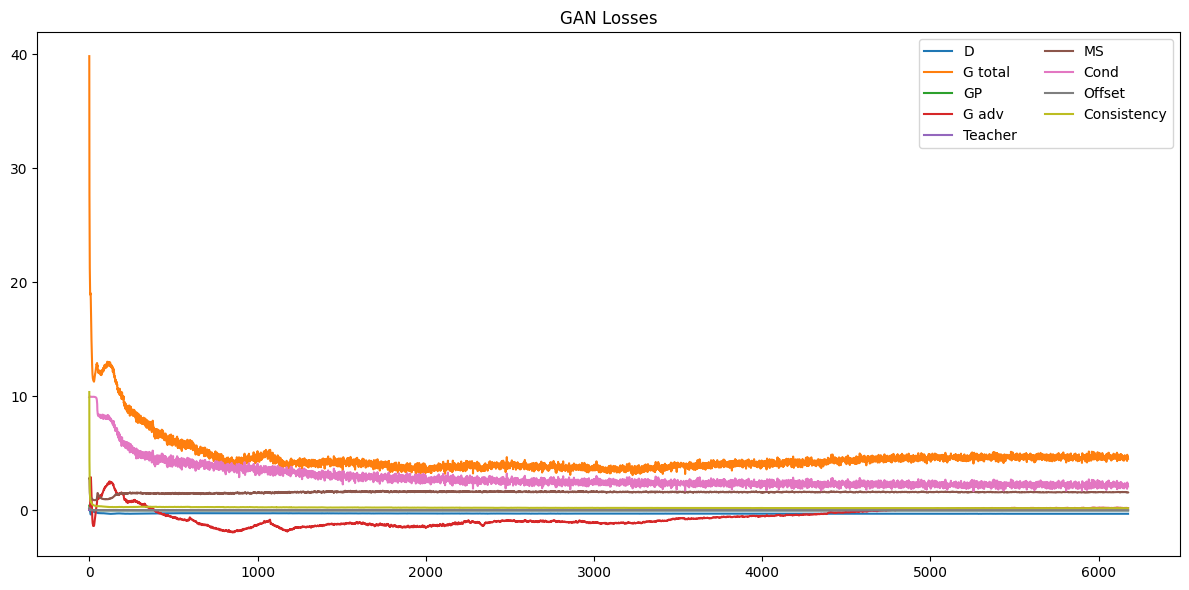

In [ ]:
# Loss curves
plt.figure(figsize=(12,6))
plt.plot(loss_hist["d"], label="D")
plt.plot(loss_hist["g"], label="G total")
plt.plot(loss_hist["gp"], label="GP")
plt.plot(loss_hist["adv"], label="G adv")
plt.plot(loss_hist["t1"], label="Teacher")
plt.plot(loss_hist["ms"], label="MS")
plt.plot(loss_hist["cond"], label="Cond")
plt.plot(loss_hist["offset"], label="Offset")
plt.plot(loss_hist["cons"], label="Consistency")
plt.legend(ncol=2)
plt.title("GAN Losses")
plt.tight_layout()
plt.show()


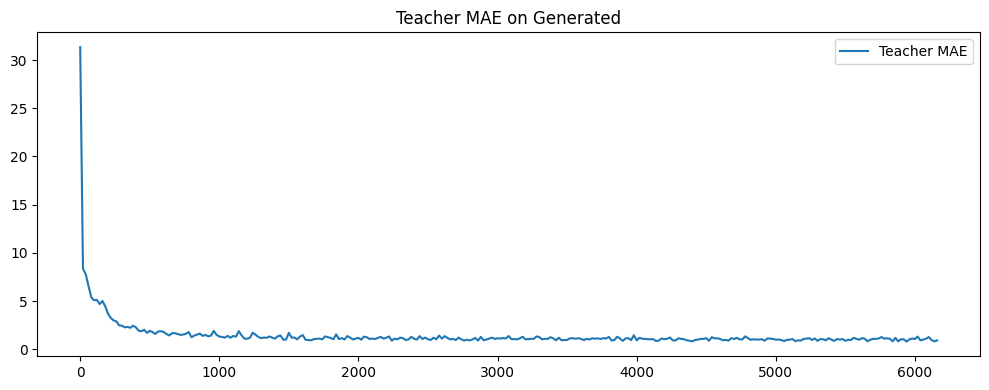

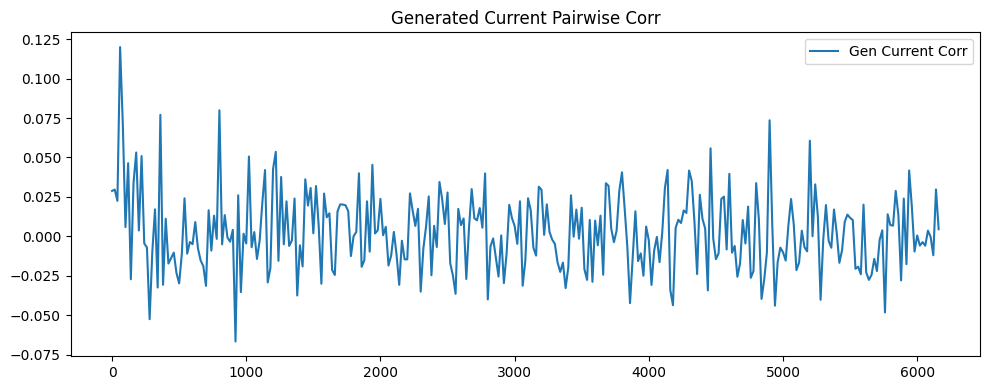

In [ ]:
# Eval metrics
if eval_hist["epoch"]:
    plt.figure(figsize=(10,4))
    plt.plot(eval_hist["epoch"], eval_hist["teacher_mae"], label="Teacher MAE")
    plt.title("Teacher MAE on Generated")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(eval_hist["epoch"], eval_hist["gen_curr_corr"], label="Gen Current Corr")
    plt.title("Generated Current Pairwise Corr")
    plt.legend()
    plt.tight_layout()
    plt.show()


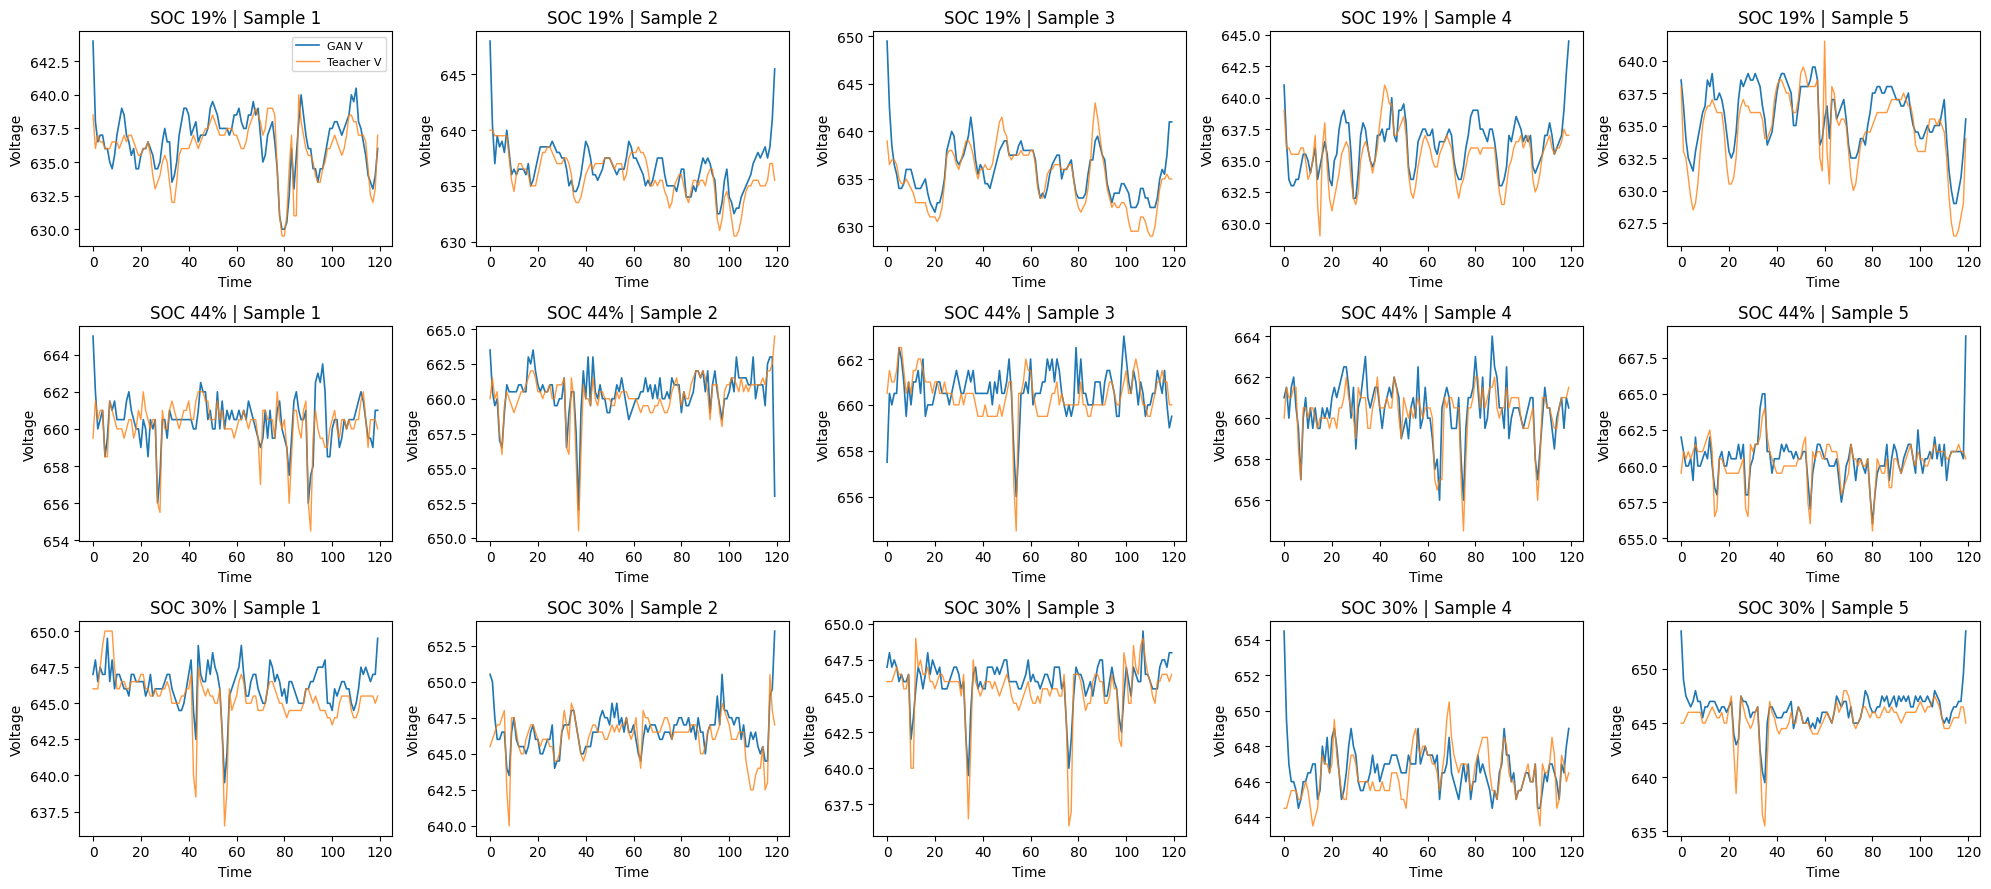

In [ ]:
# Validation plots vs Teacher (3 random SOCs, 5 samples each)
# Reference: Teacher voltage output for generated current profiles

# generator_cond = tf.keras.models.load_model(
#     r"C:\Users\user\Desktop\JANG\code\AI\260122\generator_best.h5",
#     compile=False
# )

generator_cond = tf.keras.models.load_model(
    r"C:\Users\user\Desktop\JANG\code\AI\260122\generator_epoch_6000.h5",
    compile=False
)


train_soc_denorm = denorm_feature(train_sequences[:, -1, 1], 1)
unique_socs = np.unique(train_soc_denorm.astype(int))
np.random.shuffle(unique_socs)
selected_socs = unique_socs[:3]

num_samples = 5
fig, axes = plt.subplots(len(selected_socs), num_samples, figsize=(4 * num_samples, 3 * len(selected_socs)))
if len(selected_socs) == 1:
    axes = np.expand_dims(axes, axis=0)

for row, soc_val in enumerate(selected_socs):
    scaled_soc = (soc_val - data_min[1]) / (data_max[1] - data_min[1] + 1e-7)
    cond = tf.ones((num_samples, window_size, 1), dtype=tf.float32) * scaled_soc
    noise = tf.random.normal([num_samples, window_size, latent_dim])
    latent = generator_cond([noise, cond], training=False)
    gen = combine_output(latent, cond)

    teacher_in = tf.concat([
        gen[..., :1],
        tf.cast(cond, gen.dtype),
        gen[..., 3:4],
    ], axis=-1)
    teacher_pred = teacher_model(teacher_in, training=False)

    gen_volt = denorm_feature(gen[..., 2], 2).numpy()
    teacher_volt = denorm_feature(teacher_pred[..., 0], 2).numpy()

    for col in range(num_samples):
        ax = axes[row][col]
        ax.plot(gen_volt[col], label='GAN V', linewidth=1.2)
        ax.plot(teacher_volt[col], label='Teacher V', linewidth=1.0, alpha=0.8)
        ax.set_title(f"SOC {soc_val}% | Sample {col+1}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Voltage")
        if row == 0 and col == 0:
            ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


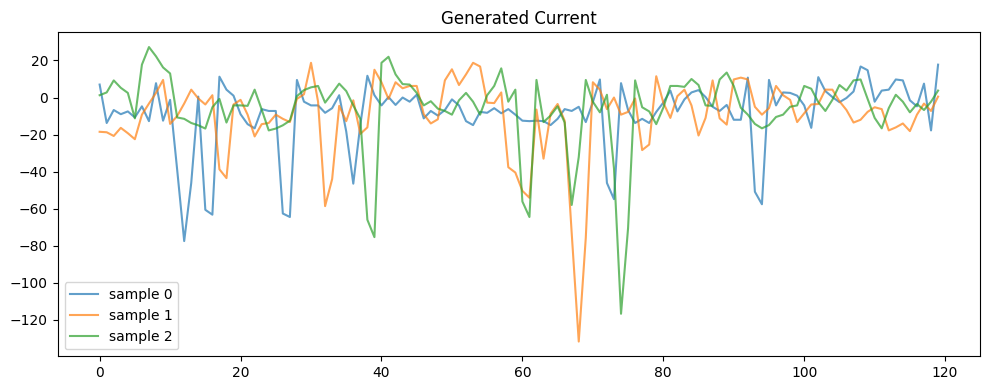

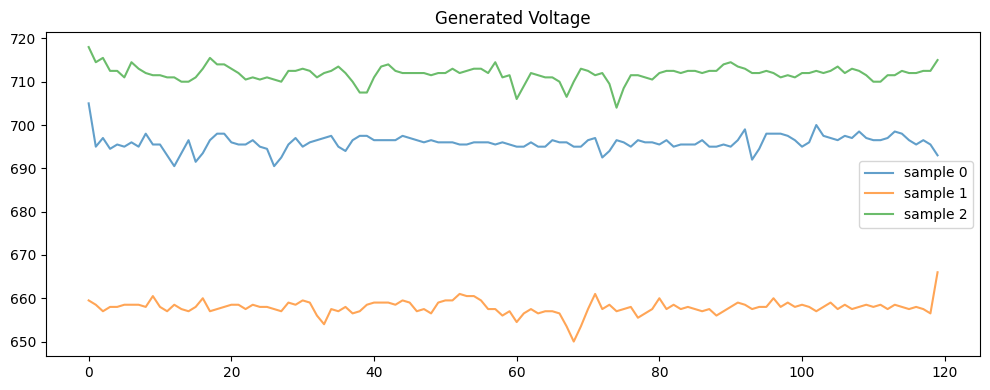

In [ ]:
# Quick generation preview
num_samples = 3
# Use random SOC from real batch
real_batch = next(iter(dataset))
cond = get_condition(real_batch[:num_samples])
noise = tf.random.normal([num_samples, window_size, latent_dim], dtype=real_batch.dtype)
latent = generator_cond([noise, cond], training=False)
gen = combine_output(latent, cond)  # [Current, SOC, Voltage, DI]

# denorm current/voltage
curr = denorm_feature(gen[..., 0], 0)
volt = denorm_feature(gen[..., 2], 2)

plt.figure(figsize=(10,4))
for i in range(num_samples):
    plt.plot(curr[i].numpy(), alpha=0.7, label=f"sample {i}")
plt.title("Generated Current")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
for i in range(num_samples):
    plt.plot(volt[i].numpy(), alpha=0.7, label=f"sample {i}")
plt.title("Generated Voltage")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Final validation (fast) with baselines: DTW NN + Teacher-embedding KNN
n_gen = 12
max_real = 100
stride = 2  # downsample for DTW speed

real_batch = next(iter(dataset))
cond = get_condition(real_batch[:n_gen])
noise = tf.random.normal([n_gen, window_size, latent_dim], dtype=real_batch.dtype)
latent = generator_cond([noise, cond], training=False)
gen = combine_output(latent, cond)

gen_curr = denorm_feature(gen[..., 0], 0).numpy()[:, ::stride]
real_curr = denorm_feature(train_sequences[:, :, 0], 0)[:, ::stride]

idx = np.random.choice(real_curr.shape[0], size=min(max_real, real_curr.shape[0]), replace=False)
real_sub = real_curr[idx]

# DTW distance

def dtw_distance(x, y):
    n = len(x)
    m = len(y)
    dtw = np.full((n + 1, m + 1), np.inf)
    dtw[0, 0] = 0.0
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = abs(x[i - 1] - y[j - 1])
            dtw[i, j] = cost + min(dtw[i - 1, j], dtw[i, j - 1], dtw[i - 1, j - 1])
    return dtw[n, m]

# Gen-Real NN
min_dtw_gr = []
for i in range(n_gen):
    dists = [dtw_distance(gen_curr[i], real_sub[j]) for j in range(real_sub.shape[0])]
    min_dtw_gr.append(min(dists))

# Real-Real NN (baseline)
min_dtw_rr = []
for i in range(real_sub.shape[0]):
    dists = [dtw_distance(real_sub[i], real_sub[j]) for j in range(real_sub.shape[0]) if j != i]
    min_dtw_rr.append(min(dists))

# Gen-Gen NN (collapse check)
min_dtw_gg = []
for i in range(n_gen):
    dists = [dtw_distance(gen_curr[i], gen_curr[j]) for j in range(n_gen) if j != i]
    min_dtw_gg.append(min(dists))

print("DTW NN mean/std: GR=%.2f/%.2f, RR=%.2f/%.2f, GG=%.2f/%.2f" % (
    np.mean(min_dtw_gr), np.std(min_dtw_gr),
    np.mean(min_dtw_rr), np.std(min_dtw_rr),
    np.mean(min_dtw_gg), np.std(min_dtw_gg),
))
print("DTW NN ratios: GR/RR=%.3f, GG/RR=%.3f" % (
    np.mean(min_dtw_gr) / (np.mean(min_dtw_rr) + 1e-9),
    np.mean(min_dtw_gg) / (np.mean(min_dtw_rr) + 1e-9),
))

# Teacher-embedding KNN
teacher_in_gen = tf.concat([
    gen[..., :1],
    tf.cast(cond, gen.dtype),
    gen[..., 3:4],
], axis=-1)

teacher_in_real = tf.concat([
    train_sequences[..., :1],
    tf.cast(get_condition(train_sequences), train_sequences.dtype),
    train_sequences[..., 3:4],
], axis=-1)

feat_gen = teacher_model_intermediate(teacher_in_gen, training=False)[0].numpy()
feat_real = teacher_model_intermediate(teacher_in_real, training=False)[0].numpy()

feat_gen_flat = feat_gen.reshape(feat_gen.shape[0], -1)
feat_real_flat = feat_real.reshape(feat_real.shape[0], -1)

idx2 = np.random.choice(feat_real_flat.shape[0], size=min(max_real, feat_real_flat.shape[0]), replace=False)
feat_real_sub = feat_real_flat[idx2]

# Gen-Real KNN
min_knn_gr = []
for i in range(feat_gen_flat.shape[0]):
    dists = np.linalg.norm(feat_real_sub - feat_gen_flat[i], axis=1)
    min_knn_gr.append(np.min(dists))

# Real-Real KNN
min_knn_rr = []
for i in range(feat_real_sub.shape[0]):
    dists = np.linalg.norm(feat_real_sub - feat_real_sub[i], axis=1)
    dists[i] = np.inf
    min_knn_rr.append(np.min(dists))

# Gen-Gen KNN
min_knn_gg = []
for i in range(feat_gen_flat.shape[0]):
    dists = np.linalg.norm(feat_gen_flat - feat_gen_flat[i], axis=1)
    dists[i] = np.inf
    min_knn_gg.append(np.min(dists))

print("KNN(teacher) mean/std: GR=%.3f/%.3f, RR=%.3f/%.3f, GG=%.3f/%.3f" % (
    np.mean(min_knn_gr), np.std(min_knn_gr),
    np.mean(min_knn_rr), np.std(min_knn_rr),
    np.mean(min_knn_gg), np.std(min_knn_gg),
))
print("KNN ratios: GR/RR=%.3f, GG/RR=%.3f" % (
    np.mean(min_knn_gr) / (np.mean(min_knn_rr) + 1e-9),
    np.mean(min_knn_gg) / (np.mean(min_knn_rr) + 1e-9),
))


DTW NN mean/std: GR=526.43/120.04, RR=509.60/322.68, GG=563.79/100.37
DTW NN ratios: GR/RR=1.033, GG/RR=1.106
KNN(teacher) mean/std: GR=1.818/0.949, RR=2.176/1.620, GG=3.504/1.993
KNN ratios: GR/RR=0.836, GG/RR=1.610


c:\Users\user\anaconda3\envs\hjjang\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


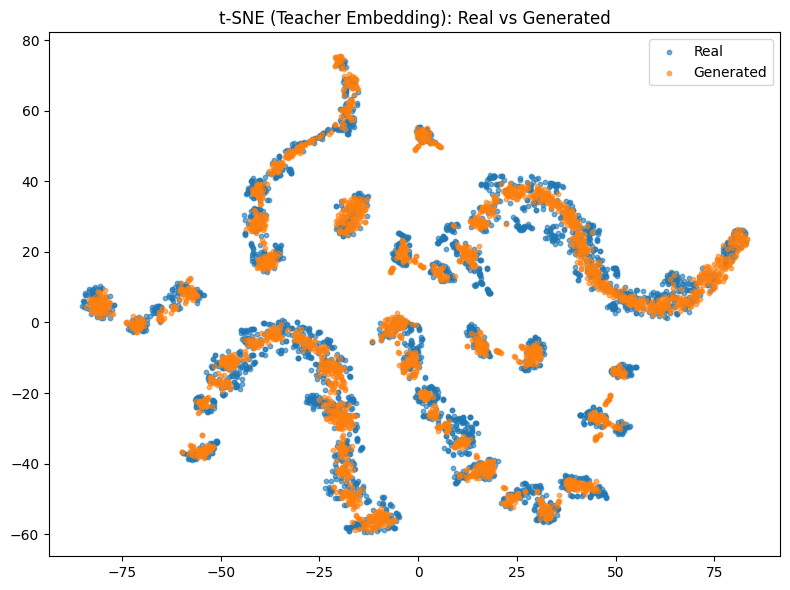

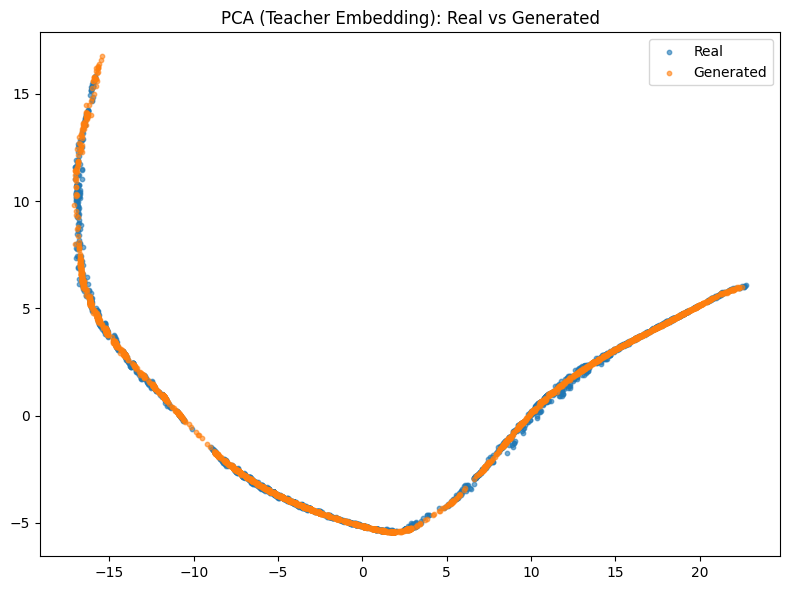

In [ ]:
# t-SNE + PCA visualization (Teacher embedding): Real vs Generated
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# ---------------------------
# Config
# ---------------------------
n_gen = 3000
n_real = 3000
perplexity = 30
seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)

# ---------------------------
# Generate Generated samples
# ---------------------------
idx_gen = np.random.choice(train_sequences.shape[0], size=n_gen, replace=False)
cond_gen = train_sequences[idx_gen, :, 1:2]   # SOC condition

noise = tf.random.normal(
    shape=(n_gen, window_size, latent_dim),
    dtype=tf.float32
)

latent = generator_cond([noise, cond_gen], training=False)
gen = combine_output(latent, cond_gen)

# ---------------------------
# Generate Real samples
# ---------------------------
idx_real = np.random.choice(train_sequences.shape[0], size=n_real, replace=False)
real_sub = train_sequences[idx_real]
cond_real = get_condition(real_sub)

# ---------------------------
# Teacher embedding inputs
# ---------------------------
teacher_in_gen = tf.concat([
    gen[..., :1],                    # Current
    tf.cast(cond_gen, gen.dtype),    # SOC
    gen[..., 3:4],                   # DI
], axis=-1)

teacher_in_real = tf.concat([
    real_sub[..., :1],               # Current
    tf.cast(cond_real, real_sub.dtype),
    real_sub[..., 3:4],              # DI
], axis=-1)

# ---------------------------
# Extract teacher intermediate features
# ---------------------------
feat_gen = teacher_model_intermediate(
    teacher_in_gen, training=False
)[0].numpy()

feat_real = teacher_model_intermediate(
    teacher_in_real, training=False
)[0].numpy()

feat_gen_flat = feat_gen.reshape(feat_gen.shape[0], -1)
feat_real_flat = feat_real.reshape(feat_real.shape[0], -1)

X = np.concatenate([feat_real_flat, feat_gen_flat], axis=0)
labels = np.array(
    [0] * feat_real_flat.shape[0] +
    [1] * feat_gen_flat.shape[0]
)

# ===========================
# t-SNE
# ===========================
tsne = TSNE(
    n_components=2,
    perplexity=min(perplexity, (X.shape[0] - 1) // 3),
    random_state=seed,
    init="pca",
    learning_rate="auto"
)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_tsne[labels == 0, 0],
    X_tsne[labels == 0, 1],
    s=10, alpha=0.6, label="Real"
)
plt.scatter(
    X_tsne[labels == 1, 0],
    X_tsne[labels == 1, 1],
    s=10, alpha=0.6, label="Generated"
)
plt.title("t-SNE (Teacher Embedding): Real vs Generated")
plt.legend()
plt.tight_layout()
plt.show()

# ===========================
# PCA (원래 방식 그대로)
# ===========================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[labels == 0, 0],
    X_pca[labels == 0, 1],
    s=10, alpha=0.6, label="Real"
)
plt.scatter(
    X_pca[labels == 1, 0],
    X_pca[labels == 1, 1],
    s=10, alpha=0.6, label="Generated"
)
plt.title("PCA (Teacher Embedding): Real vs Generated")
plt.legend()
plt.tight_layout()
plt.show()


TRAIN_EPOCHS = 300
BATCH_SIZE   = 256
REAL train/test: (4213, 120, 3) (1054, 120, 3)
GEN(match train N) shapes: (4213, 120, 3) (4213, 120)
[OK] X_gen is finite.
[OK] y_gen is finite.
[OK] X_real_train is finite.
[OK] y_real_train is finite.
[TRTR-full] MAE: 1.0936, RMSE: 1.3780
[TSTR-full] MAE: 1.3810, RMSE: 1.7784


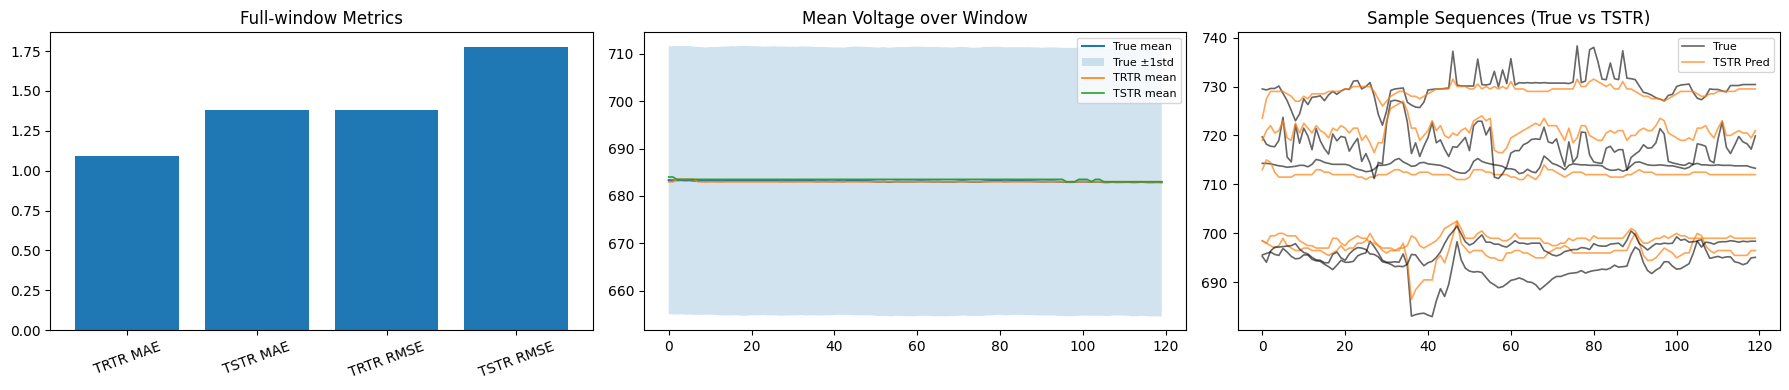

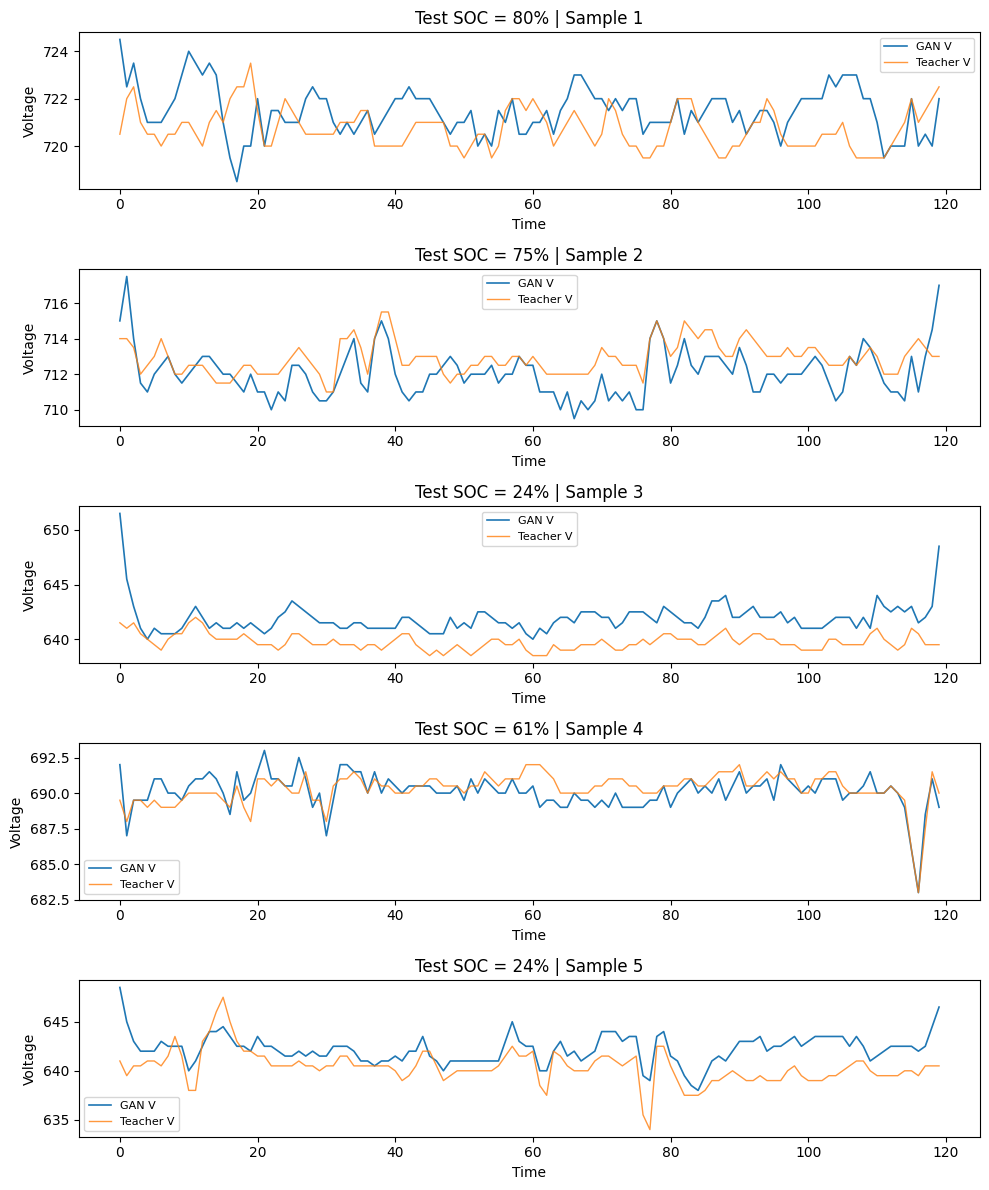

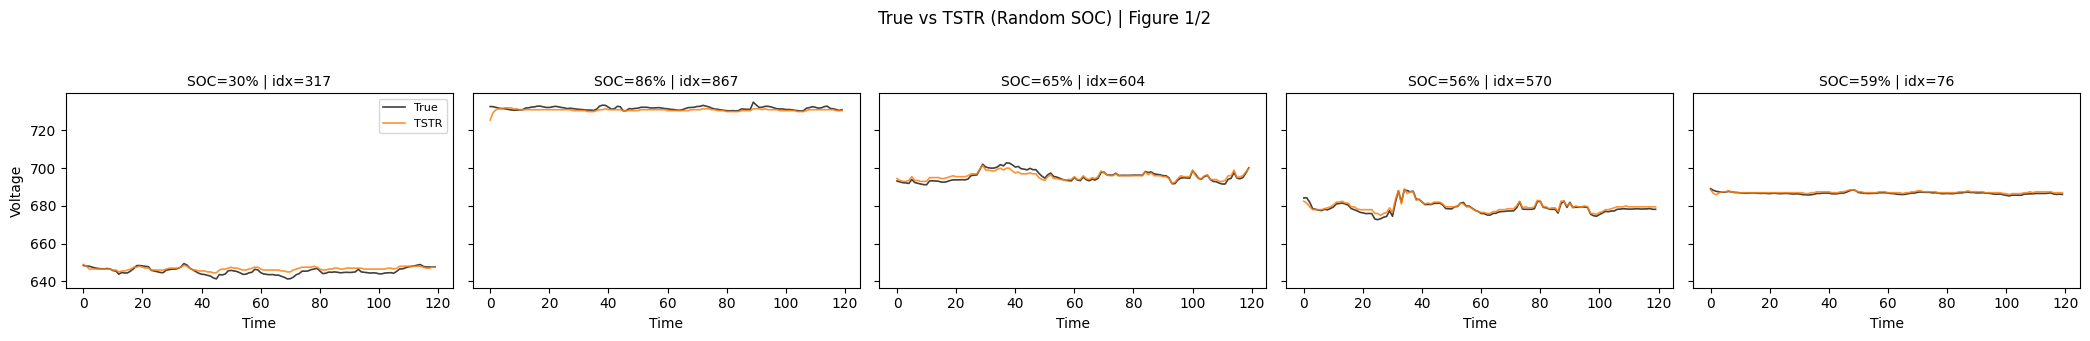

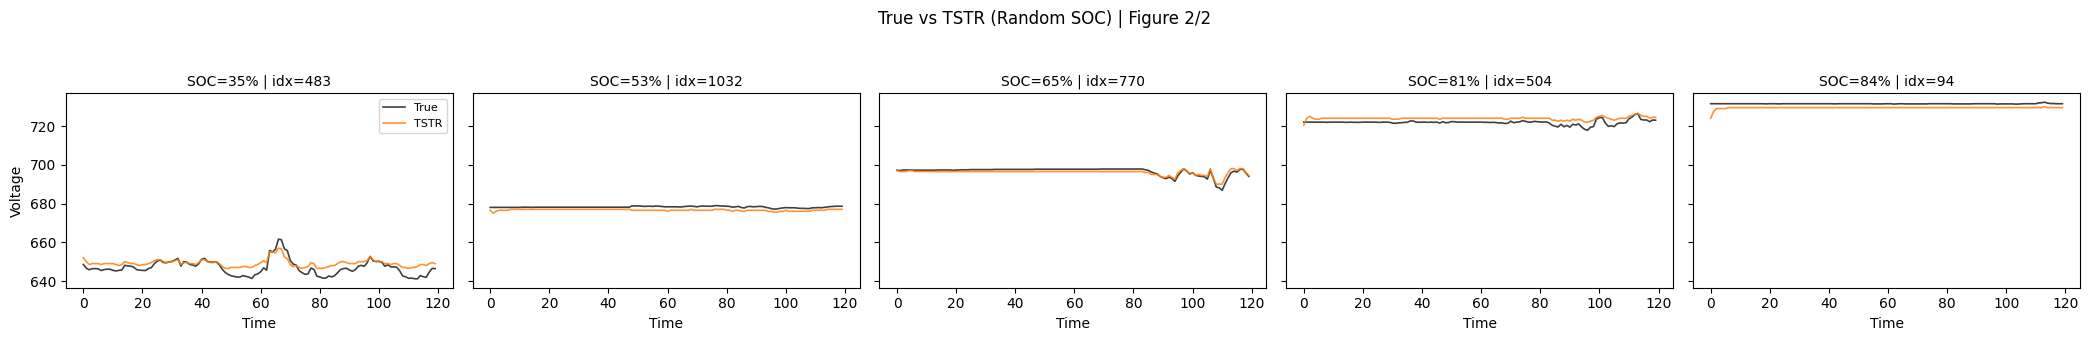

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# -----------------------------
# Config (이미 정의돼 있으면 그대로 사용)
# -----------------------------
try:
    N_COND
except NameError:
    N_COND = 100000  # (이제 match 방식에서는 직접 쓰지 않지만 남겨둠)

try:
    K_PER_COND
except NameError:
    K_PER_COND = 3   # (이제 match 방식에서는 직접 쓰지 않지만 남겨둠)

try:
    GEN_BATCH
except NameError:
    GEN_BATCH = 256

try:
    TRAIN_EPOCHS
except NameError:
    TRAIN_EPOCHS = 50

try:
    BATCH_SIZE
except NameError:
    BATCH_SIZE = 256

TRAIN_EPOCHS = 300
BATCH_SIZE = 256
print("TRAIN_EPOCHS =", TRAIN_EPOCHS)
print("BATCH_SIZE   =", BATCH_SIZE)

# 재현성(원하면)
SEED = 7
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -----------------------------
# Utilities: X, y 선택
# train_sequences: (N, T, 4) 가정: [I, SOC, V, DI]
# X: [I, SOC, DI] (3채널)
# y: V (full window, seq2seq)
# -----------------------------
def pick_X(seq_np):
    return seq_np[..., [0, 1, 3]].astype(np.float32)

def pick_y_windowV(seq_np):
    return seq_np[..., 2].astype(np.float32)

# -----------------------------
# GRU seq-to-seq regressor
# NOTE: 회귀라면 sigmoid는 보통 비권장.
# 여기서는 "정규화된 전압(0~1)"을 예측한다는 전제일 때만 sigmoid가 합리적입니다.
# 사용하신 denorm_feature 구조상 전압이 0~1로 normalize된 상태일 확률이 높아 그대로 두되,
# 필요하면 activation=None 로 바꾸면 됩니다.
# -----------------------------
def build_gru_seq_regressor(use_sigmoid=True):
    inp = Input(shape=(window_size, 3), dtype=tf.float32)
    x = GRU(64, return_sequences=True)(inp)
    x = GRU(32, return_sequences=True)(x)
    if use_sigmoid:
        out = Dense(1, activation='sigmoid')(x)
    else:
        out = Dense(1, activation=None)(x)
    model = Model(inp, out, name='GRU_Seq_Regressor')
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return model

# -----------------------------
# (핵심) REAL train 개수에 "정확히 맞춰" 생성
# - cond는 train_sequences에서 SOC 시퀀스를 샘플링(부족하면 반복)
# - 출력: X_gen (Ntrain, T, 3), y_gen (Ntrain, T)
# -----------------------------
def generate_synth_match_train_count(train_sequences, target_N, gen_batch=256):
    N_avail = train_sequences.shape[0]
    cond_all = train_sequences[:, :, 1:2].astype(np.float32)  # (N, T, 1)

    if target_N <= N_avail:
        idx = np.random.choice(N_avail, size=target_N, replace=False)
    else:
        reps = target_N // N_avail
        rem  = target_N % N_avail
        idx = np.concatenate([
            np.tile(np.arange(N_avail), reps),
            np.random.choice(N_avail, size=rem, replace=False)
        ], axis=0)
        np.random.shuffle(idx)

    cond_big = tf.convert_to_tensor(cond_all[idx], dtype=tf.float32)  # (target_N, T, 1)

    X_list, y_list = [], []
    for s in range(0, target_N, gen_batch):
        e = min(s + gen_batch, target_N)
        cond = cond_big[s:e]
        noise = tf.random.normal([e - s, window_size, latent_dim], dtype=tf.float32)

        latent = generator_cond([noise, cond], training=False)
        seq_gen = combine_output(latent, cond)  # (B, T, 4): [I,SOC,V,DI] 가정

        # X=[I,SOC,DI], y=V
        Xb = tf.gather(seq_gen, indices=[0, 1, 3], axis=-1)
        yb = tf.gather(seq_gen, indices=[2], axis=-1)  # (B, T, 1)

        X_list.append(Xb.numpy().astype(np.float32))
        y_list.append(yb.numpy().astype(np.float32))

    X_gen = np.concatenate(X_list, axis=0)            # (N, T, 3)
    y_gen = np.concatenate(y_list, axis=0)[..., 0]    # (N, T)
    return X_gen, y_gen

# -----------------------------
# 1) REAL train/test split
# - 주의: 지금은 window 단위 랜덤 split입니다(동일 사이클 누출 가능).
#   일단 요청대로 유지합니다.
# -----------------------------
N_real_all = train_sequences.shape[0]
idx_real = np.arange(N_real_all)
real_subset = train_sequences[idx_real]

X_real = pick_X(real_subset)           # (N, T, 3)
y_real = pick_y_windowV(real_subset)   # (N, T)

perm = np.random.permutation(X_real.shape[0])
split = int(0.8 * len(perm))
train_idx = perm[:split]
test_idx  = perm[split:]

X_real_train = X_real[train_idx]
y_real_train = y_real[train_idx]
X_real_test  = X_real[test_idx]
y_real_test  = y_real[test_idx]

print('REAL train/test:', X_real_train.shape, X_real_test.shape)

# -----------------------------
# 2) SYNTH 생성: "train 개수"에 정확히 맞춤
# -----------------------------
target_N = X_real_train.shape[0]
X_gen, y_gen = generate_synth_match_train_count(
    train_sequences=train_sequences,
    target_N=target_N,
    gen_batch=GEN_BATCH
)
print('GEN(match train N) shapes:', X_gen.shape, y_gen.shape)

# (안전) NaN/inf 체크: overflow 경고 방지용
def check_finite(name, arr):
    finite = np.isfinite(arr).all()
    if not finite:
        bad = np.where(~np.isfinite(arr))
        print(f'[WARN] {name} contains non-finite values. Example idx:', tuple(b[0] for b in bad))
    else:
        print(f'[OK] {name} is finite.')
check_finite("X_gen", X_gen)
check_finite("y_gen", y_gen)
check_finite("X_real_train", X_real_train)
check_finite("y_real_train", y_real_train)

# -----------------------------
# 3) TRTR: real_train으로 학습 후 real_test 평가
# -----------------------------
model_trtr = build_gru_seq_regressor(use_sigmoid=True)
model_trtr.fit(X_real_train, y_real_train, epochs=TRAIN_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
pred_trtr = model_trtr.predict(X_real_test, verbose=0)[..., 0]  # (Ntest, T)

# -----------------------------
# 4) TSTR: gen_train으로 학습 후 real_test 평가
# -----------------------------
model_tstr = build_gru_seq_regressor(use_sigmoid=True)
model_tstr.fit(X_gen, y_gen, epochs=TRAIN_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
pred_tstr = model_tstr.predict(X_real_test, verbose=0)[..., 0]  # (Ntest, T)

# -----------------------------
# 5) Metrics (denorm: Voltage index=2)
# -----------------------------
true_dn      = denorm_feature(y_real_test, 2)     # (Ntest, T) expected
pred_trtr_dn = denorm_feature(pred_trtr, 2)
pred_tstr_dn = denorm_feature(pred_tstr, 2)

err_trtr = true_dn - pred_trtr_dn
err_tstr = true_dn - pred_tstr_dn

mae_trtr  = float(np.mean(np.abs(err_trtr)))
rmse_trtr = float(np.sqrt(np.mean(err_trtr**2)))
mae_tstr  = float(np.mean(np.abs(err_tstr)))
rmse_tstr = float(np.sqrt(np.mean(err_tstr**2)))

print(f'[TRTR-full] MAE: {mae_trtr:.4f}, RMSE: {rmse_trtr:.4f}')
print(f'[TSTR-full] MAE: {mae_tstr:.4f}, RMSE: {rmse_tstr:.4f}')

# -----------------------------
# 6) Plots (full window)
# -----------------------------
plt.figure(figsize=(18, 4))

# (a) Bar metrics
plt.subplot(1, 3, 1)
plt.bar(['TRTR MAE','TSTR MAE','TRTR RMSE','TSTR RMSE'],
        [mae_trtr, mae_tstr, rmse_trtr, rmse_tstr])
plt.title('Full-window Metrics')
plt.xticks(rotation=20)

# (b) Mean over time + std band
plt.subplot(1, 3, 2)
mean_true = np.mean(true_dn, axis=0)
std_true  = np.std(true_dn, axis=0)
mean_trtr = np.mean(pred_trtr_dn, axis=0)
mean_tstr = np.mean(pred_tstr_dn, axis=0)
plt.plot(mean_true, label='True mean', linewidth=1.5)
plt.fill_between(np.arange(len(mean_true)),
                 mean_true-std_true, mean_true+std_true,
                 alpha=0.2, label='True ±1std')
plt.plot(mean_trtr, label='TRTR mean', linewidth=1.2)
plt.plot(mean_tstr, label='TSTR mean', linewidth=1.2)
plt.title('Mean Voltage over Window')
plt.legend(fontsize=8)

# (c) Sample sequences (random): True vs TSTR
plt.subplot(1, 3, 3)
sample_n = min(5, true_dn.shape[0])
sel = np.random.choice(true_dn.shape[0], size=sample_n, replace=False)
for i, idx_s in enumerate(sel):
    plt.plot(true_dn[idx_s], color='black', alpha=0.6, linewidth=1.2, label='True' if i == 0 else None)
    plt.plot(pred_tstr_dn[idx_s], color='tab:orange', alpha=0.7, linewidth=1.2, label='TSTR Pred' if i == 0 else None)
plt.title('Sample Sequences (True vs TSTR)')
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

# -----------------------------
# 7) Teacher vs GAN voltage (5 random SOCs from test data)
#    - SOC 정수로 표기: "첫 타임스텝 SOC"를 denorm -> round/int
# -----------------------------
num_samples = min(5, X_real_test.shape[0])
sel = np.random.choice(X_real_test.shape[0], size=num_samples, replace=False)

fig, axes = plt.subplots(num_samples, 1, figsize=(10, 2.4 * num_samples))
if num_samples == 1:
    axes = [axes]

for i, idx_s in enumerate(sel):
    # SOC from real test sample (normalized SOC seq)
    soc_seq = X_real_test[idx_s:idx_s+1, :, 1:2]  # (1, T, 1)
    cond = tf.convert_to_tensor(soc_seq, dtype=tf.float32)

    noise = tf.random.normal([1, window_size, latent_dim], dtype=tf.float32)
    latent = generator_cond([noise, cond], training=False)
    gen = combine_output(latent, cond)

    # teacher input: [I, SOC, DI] -> teacher predicts V
    teacher_in = tf.concat([
        gen[..., :1],
        tf.cast(cond, gen.dtype),
        gen[..., 3:4],
    ], axis=-1)
    teacher_pred = teacher_model(teacher_in, training=False)

    gen_volt = denorm_feature(gen[..., 2], 2).numpy()[0]
    teacher_volt = denorm_feature(teacher_pred[..., 0], 2).numpy()[0]

    # SOC 표시: 첫 시점 SOC를 정수로
    soc_first = float(denorm_feature(soc_seq[0, 0, 0], 1))
    soc_int = int(round(soc_first))

    axes[i].plot(gen_volt, label='GAN V', linewidth=1.2)
    axes[i].plot(teacher_volt, label='Teacher V', linewidth=1.0, alpha=0.8)
    axes[i].set_title(f"Test SOC = {soc_int}% | Sample {i+1}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Voltage")
    axes[i].legend(fontsize=8)

plt.tight_layout()
plt.show()

# -----------------------------
# (추가) True vs TSTR: Random SOC 10개를 2개 Figure(각 5개 가로)로 시각화
# -----------------------------
n_total = min(10, true_dn.shape[0])
sel10 = np.random.choice(true_dn.shape[0], size=n_total, replace=False)

# SOC 값(정수) 계산: 각 샘플의 첫 타임스텝 SOC를 사용
soc_int_list = []
for idx_s in sel10:
    # X_real_test: (N, T, 3) where channels=[I,SOC,DI]
    soc_first_norm = X_real_test[idx_s, 0, 1]          # 첫 타임스텝 SOC (normalized)
    soc_first = float(denorm_feature(soc_first_norm, 1))  # denorm -> %
    soc_int_list.append(int(round(soc_first)))

# 2개 Figure로 나눠 그리기 (0~4, 5~9)
for fig_id in range(2):
    start = fig_id * 5
    end = min(start + 5, n_total)
    if start >= end:
        break

    fig, axes = plt.subplots(1, end - start, figsize=(4.2 * (end - start), 3.2), sharey=True)
    if (end - start) == 1:
        axes = [axes]

    for j, ax in enumerate(axes):
        idx_s = sel10[start + j]
        soc_i = soc_int_list[start + j]

        ax.plot(true_dn[idx_s], color='black', linewidth=1.2, alpha=0.75, label='True')
        ax.plot(pred_tstr_dn[idx_s], color='tab:orange', linewidth=1.2, alpha=0.85, label='TSTR')

        ax.set_title(f"SOC={soc_i}% | idx={idx_s}", fontsize=10)
        ax.set_xlabel("Time")
        if j == 0:
            ax.set_ylabel("Voltage")

        # 범례는 첫 subplot에만
        if j == 0:
            ax.legend(fontsize=8)

    plt.suptitle(f"True vs TSTR (Random SOC) | Figure {fig_id+1}/2", y=1.05, fontsize=12)
    plt.tight_layout()
    plt.show()


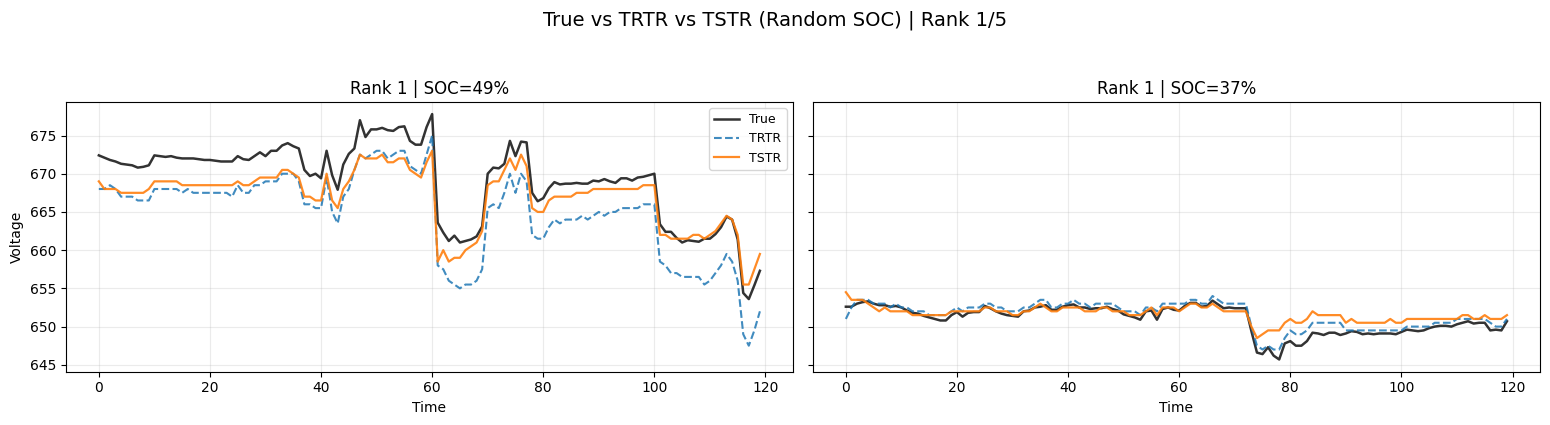

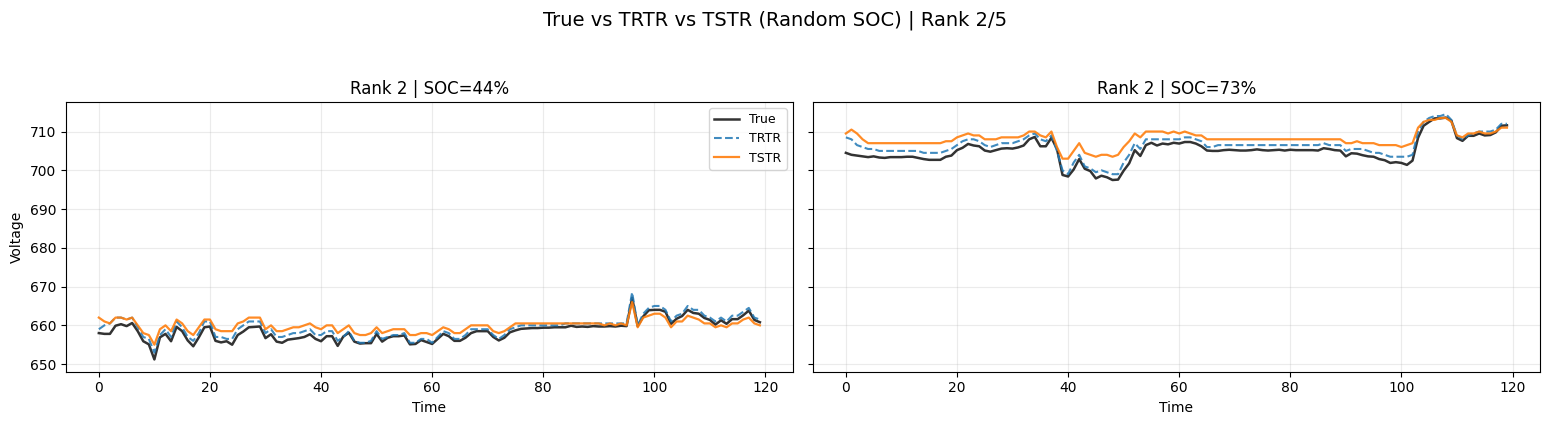

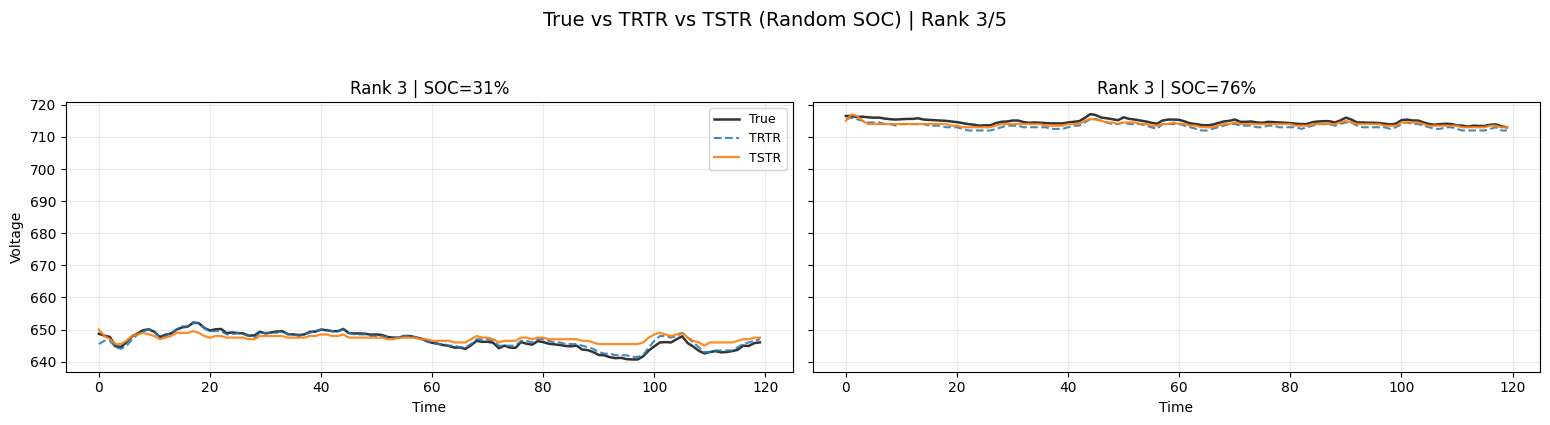

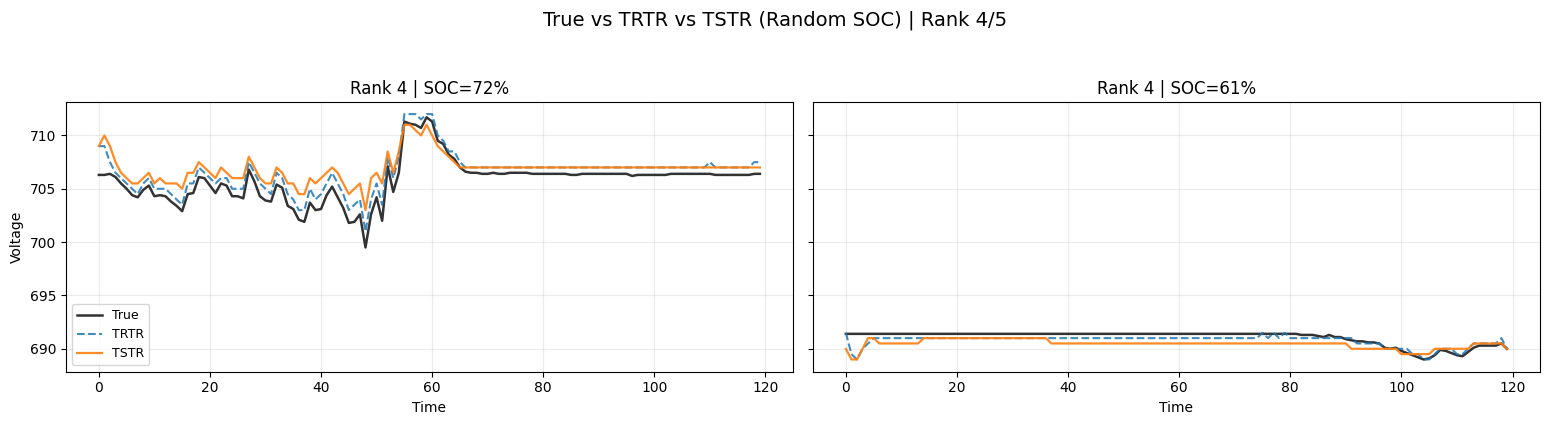

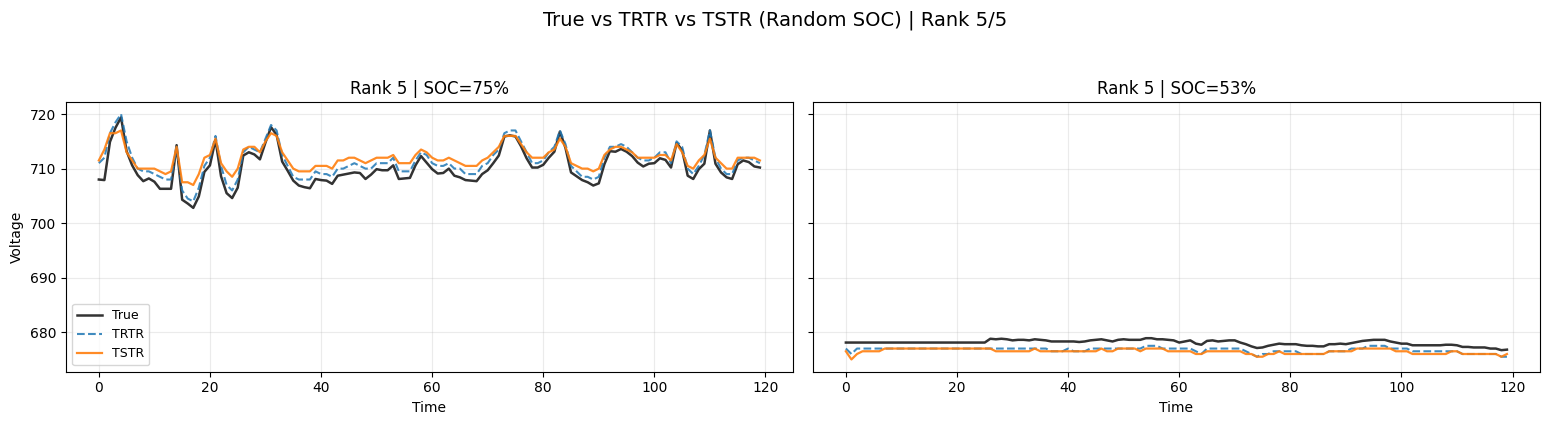

In [ ]:
# -----------------------------
# (수정) True vs TRTR vs TSTR
# Random SOC 10개를 "2개씩" 5개 Figure로 시각화 (5 Rank)
# -----------------------------
n_total = min(10, true_dn.shape[0])
sel10 = np.random.choice(true_dn.shape[0], size=n_total, replace=False)

# SOC 값(정수): 첫 타임스텝 SOC 사용
soc_int_list = []
for idx_s in sel10:
    soc_first_norm = X_real_test[idx_s, 0, 1]               # normalized SOC
    soc_first = float(denorm_feature(soc_first_norm, 1))    # denorm -> %
    soc_int_list.append(int(round(soc_first)))

# 2개씩 묶기 → 총 5 Rank
pairs = [(0,1), (2,3), (4,5), (6,7), (8,9)]

for rank, (a, b) in enumerate(pairs, start=1):
    if a >= n_total:
        break

    indices = [a] if b >= n_total else [a, b]

    fig, axes = plt.subplots(
        1, len(indices),
        figsize=(7.8 * len(indices), 4.0),
        sharey=True
    )
    if len(indices) == 1:
        axes = [axes]

    for j, idx_in_pair in enumerate(indices):
        idx_s = sel10[idx_in_pair]
        soc_i = soc_int_list[idx_in_pair]
        ax = axes[j]

        # --- Plot ---
        ax.plot(
            true_dn[idx_s],
            color='black', linewidth=1.8, alpha=0.80,
            label='True'
        )
        ax.plot(
            pred_trtr_dn[idx_s],
            color='tab:blue', linewidth=1.5, alpha=0.85,
            linestyle='--',
            label='TRTR'
        )
        ax.plot(
            pred_tstr_dn[idx_s],
            color='tab:orange', linewidth=1.6, alpha=0.90,
            label='TSTR'
        )

        ax.set_title(f"Rank {rank} | SOC={soc_i}%", fontsize=12)
        ax.set_xlabel("Time")
        if j == 0:
            ax.set_ylabel("Voltage")
            ax.legend(fontsize=9)

        ax.grid(alpha=0.25)

    plt.suptitle(
        f"True vs TRTR vs TSTR (Random SOC) | Rank {rank}/5",
        y=1.05, fontsize=14
    )
    plt.tight_layout()
    plt.show()


REAL train/test: (4213, 120, 3) (1054, 120, 3)
[AUG x1] TRTR MAE 1.9453 RMSE 2.8298 | TSTR MAE 2.4697 RMSE 3.4027
[AUG x2] TRTR MAE 1.6948 RMSE 2.4592 | TSTR MAE 1.7741 RMSE 2.3126
[AUG x5] TRTR MAE 1.6966 RMSE 2.5675 | TSTR MAE 1.5376 RMSE 1.9825
[AUG x10] TRTR MAE 1.6787 RMSE 2.4329 | TSTR MAE 1.3584 RMSE 1.7511
[AUG x20] TRTR MAE 1.8790 RMSE 2.7111 | TSTR MAE 1.3115 RMSE 1.6999
[AUG x30] TRTR MAE 1.6468 RMSE 2.3921 | TSTR MAE 1.3015 RMSE 1.6761


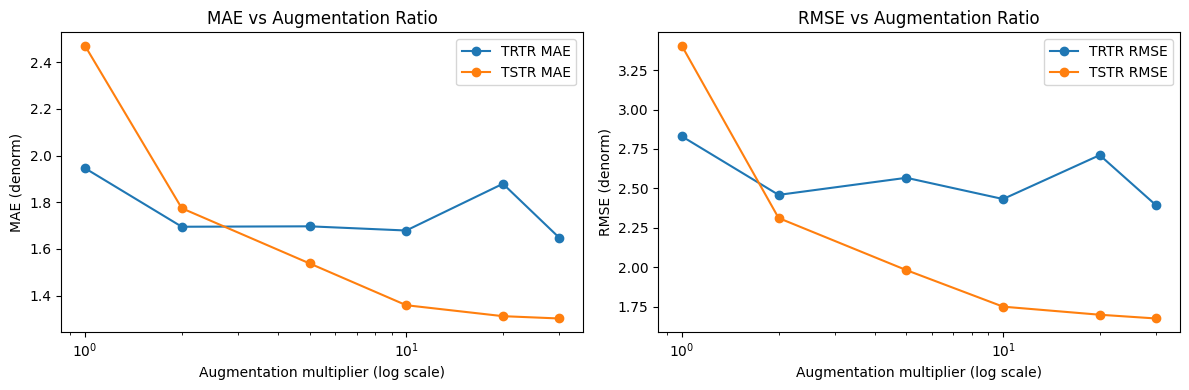

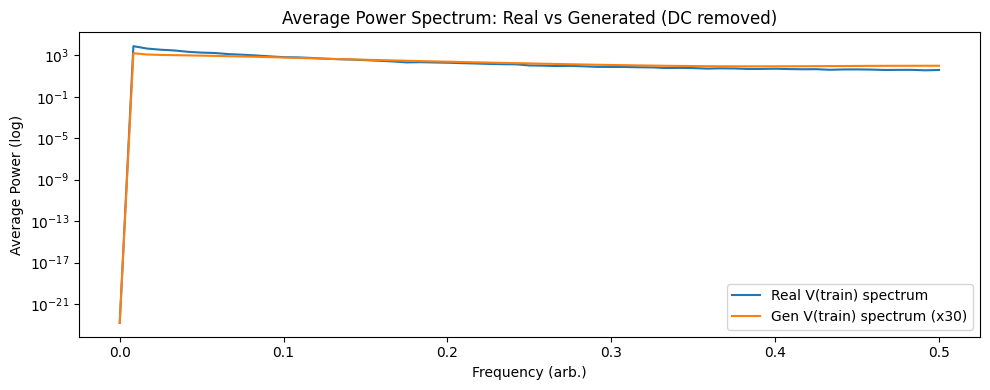

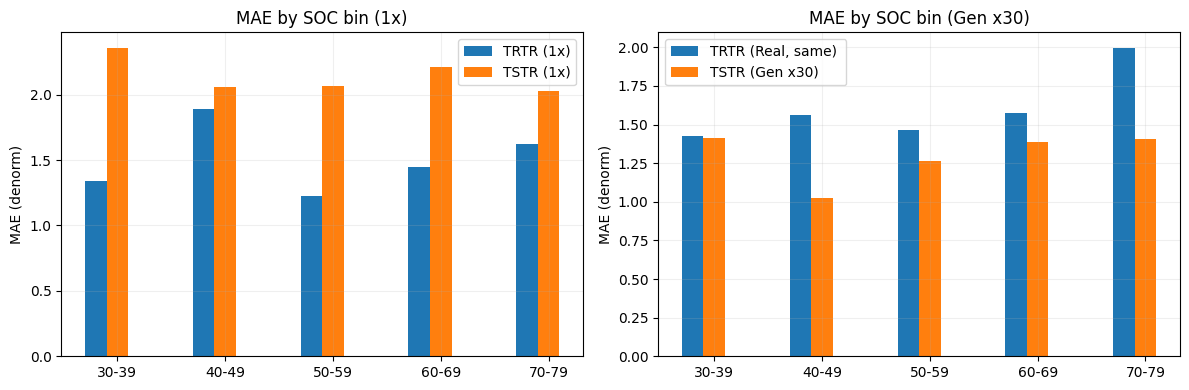

SOC bin counts: {'30-39': 88, '40-49': 147, '50-59': 197, '60-69': 204, '70-79': 165}


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math

TRAIN_EPOCHS = 30
BATCH_SIZE = 256

# ============================================================
# 공통 유틸
# ============================================================
def build_gru_seq_regressor(use_sigmoid=True):
    inp = tf.keras.layers.Input(shape=(window_size, 3), dtype=tf.float32)
    x = tf.keras.layers.GRU(64, return_sequences=True)(inp)
    x = tf.keras.layers.GRU(32, return_sequences=True)(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid' if use_sigmoid else None)(x)
    model = tf.keras.Model(inp, out, name='GRU_Seq_Regressor')
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')
    return model

def pick_X(seq_np):  # [I,SOC,DI]
    return seq_np[..., [0,1,3]].astype(np.float32)

def pick_y_windowV(seq_np):  # V
    return seq_np[..., 2].astype(np.float32)

def generate_synth_targetN(train_sequences, target_N, gen_batch=256, seed=None):
    """
    target_N개 만큼 생성 (X=[I,SOC,DI], y=V full-window).
    cond는 train_sequences의 SOC 시퀀스를 샘플링(부족하면 반복).
    """
    if seed is not None:
        np.random.seed(seed)
        tf.random.set_seed(seed)

    N_avail = train_sequences.shape[0]
    cond_all = train_sequences[:, :, 1:2].astype(np.float32)  # (N, T, 1)

    if target_N <= N_avail:
        idx = np.random.choice(N_avail, size=target_N, replace=False)
    else:
        reps = target_N // N_avail
        rem  = target_N % N_avail
        idx = np.concatenate([
            np.tile(np.arange(N_avail), reps),
            np.random.choice(N_avail, size=rem, replace=False)
        ], axis=0)
        np.random.shuffle(idx)

    cond_big = tf.convert_to_tensor(cond_all[idx], dtype=tf.float32)

    X_list, y_list = [], []
    for s in range(0, target_N, gen_batch):
        e = min(s + gen_batch, target_N)
        cond = cond_big[s:e]
        noise = tf.random.normal([e - s, window_size, latent_dim], dtype=tf.float32)

        latent = generator_cond([noise, cond], training=False)
        seq_gen = combine_output(latent, cond)  # (B, T, 4): [I,SOC,V,DI] 가정

        Xb = tf.gather(seq_gen, indices=[0,1,3], axis=-1)  # (B,T,3)
        yb = tf.gather(seq_gen, indices=[2], axis=-1)      # (B,T,1)

        X_list.append(Xb.numpy().astype(np.float32))
        y_list.append(yb.numpy().astype(np.float32))

    X_gen = np.concatenate(X_list, axis=0)
    y_gen = np.concatenate(y_list, axis=0)[...,0]  # (N,T)
    return X_gen, y_gen

def eval_trtr_tstr_fullwindow(X_real_train, y_real_train, X_real_test, y_real_test,
                              X_gen, y_gen, train_epochs=50, batch_size=256,
                              use_sigmoid=True, seed=None):
    """
    TRTR: real_train으로 학습 → real_test 평가
    TSTR: gen_train으로 학습  → real_test 평가
    """
    if seed is not None:
        np.random.seed(seed)
        tf.random.set_seed(seed)

    tf.keras.backend.clear_session()

    # TRTR
    model_trtr = build_gru_seq_regressor(use_sigmoid=use_sigmoid)
    model_trtr.fit(X_real_train, y_real_train, epochs=train_epochs, batch_size=batch_size, verbose=0)
    pred_trtr = model_trtr.predict(X_real_test, verbose=0)[...,0]  # (Ntest,T)

    # TSTR
    model_tstr = build_gru_seq_regressor(use_sigmoid=use_sigmoid)
    model_tstr.fit(X_gen, y_gen, epochs=train_epochs, batch_size=batch_size, verbose=0)
    pred_tstr = model_tstr.predict(X_real_test, verbose=0)[...,0]

    # denorm (Voltage index=2)
    true_dn      = denorm_feature(y_real_test, 2)
    pred_trtr_dn = denorm_feature(pred_trtr, 2)
    pred_tstr_dn = denorm_feature(pred_tstr, 2)

    err_trtr = true_dn - pred_trtr_dn
    err_tstr = true_dn - pred_tstr_dn

    mae_trtr  = float(np.mean(np.abs(err_trtr)))
    rmse_trtr = float(np.sqrt(np.mean(err_trtr**2)))
    mae_tstr  = float(np.mean(np.abs(err_tstr)))
    rmse_tstr = float(np.sqrt(np.mean(err_tstr**2)))

    return {
        "mae_trtr": mae_trtr, "rmse_trtr": rmse_trtr,
        "mae_tstr": mae_tstr, "rmse_tstr": rmse_tstr,
        "true_dn": true_dn, "pred_trtr_dn": pred_trtr_dn, "pred_tstr_dn": pred_tstr_dn
    }

# ============================================================
# 0) Real train/test 준비 (지금까지 하신 방식 그대로)
# ============================================================
N_real_all = train_sequences.shape[0]
X_real = pick_X(train_sequences)
y_real = pick_y_windowV(train_sequences)

perm = np.random.permutation(X_real.shape[0])
split = int(0.8 * len(perm))
train_idx = perm[:split]
test_idx  = perm[split:]

X_real_train = X_real[train_idx]
y_real_train = y_real[train_idx]
X_real_test  = X_real[test_idx]
y_real_test  = y_real[test_idx]

print("REAL train/test:", X_real_train.shape, X_real_test.shape)

# ============================================================
# 1) 증강 비율 스윕 (1x,2x,5x,10x,20x,30x 등)
#    - TSTR은 생성 데이터만으로 학습 (현재 정의 그대로)
#    - 공정 비교를 더 엄밀히 하려면 step 수 고정이 더 좋지만, 요청대로 ratio 실험을 먼저 구현합니다.
# ============================================================
AUG_MULTS = [1, 2, 5, 10, 20, 30]
sweep_results = []

baseN = X_real_train.shape[0]
for m in AUG_MULTS:
    target_N = baseN * m
    X_gen_m, y_gen_m = generate_synth_targetN(
        train_sequences=train_sequences,
        target_N=target_N,
        gen_batch=GEN_BATCH,
        seed=SEED + m
    )
    out = eval_trtr_tstr_fullwindow(
        X_real_train, y_real_train, X_real_test, y_real_test,
        X_gen_m, y_gen_m,
        train_epochs=TRAIN_EPOCHS,
        batch_size=BATCH_SIZE,
        use_sigmoid=True,
        seed=SEED + 100 + m
    )
    sweep_results.append((m, out["mae_trtr"], out["rmse_trtr"], out["mae_tstr"], out["rmse_tstr"]))
    print(f"[AUG x{m}] TRTR MAE {out['mae_trtr']:.4f} RMSE {out['rmse_trtr']:.4f} | "
          f"TSTR MAE {out['mae_tstr']:.4f} RMSE {out['rmse_tstr']:.4f}")

# 스윕 플롯
ms = [r[0] for r in sweep_results]
mae_trtr_list  = [r[1] for r in sweep_results]
rmse_trtr_list = [r[2] for r in sweep_results]
mae_tstr_list  = [r[3] for r in sweep_results]
rmse_tstr_list = [r[4] for r in sweep_results]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(ms, mae_trtr_list, marker='o', label="TRTR MAE")
plt.plot(ms, mae_tstr_list, marker='o', label="TSTR MAE")
plt.xscale("log")
plt.xlabel("Augmentation multiplier (log scale)")
plt.ylabel("MAE (denorm)")
plt.title("MAE vs Augmentation Ratio")
plt.legend()

plt.subplot(1,2,2)
plt.plot(ms, rmse_trtr_list, marker='o', label="TRTR RMSE")
plt.plot(ms, rmse_tstr_list, marker='o', label="TSTR RMSE")
plt.xscale("log")
plt.xlabel("Augmentation multiplier (log scale)")
plt.ylabel("RMSE (denorm)")
plt.title("RMSE vs Augmentation Ratio")
plt.legend()

plt.tight_layout()
plt.show()

# ============================================================
# 2) FFT(스펙트럼) 분석
#    - Real V(train) vs Generated V(train) 의 "고주파 성분(노이즈)" 비교
#    - 방법: 각 시퀀스에서 (시퀀스-시퀀스평균) 후 rFFT magnitude^2 평균(파워 스펙트럼) 계산
# ============================================================
def avg_power_spectrum(seqs_2d):
    """
    seqs_2d: (N,T) in denorm scale
    return: freqs (T/2+1), avg_power (T/2+1)
    """
    x = seqs_2d.astype(np.float64)
    x = x - x.mean(axis=1, keepdims=True)  # DC 제거
    X = np.fft.rfft(x, axis=1)
    P = (np.abs(X) ** 2)
    avgP = P.mean(axis=0)
    freqs = np.fft.rfftfreq(x.shape[1], d=1.0)  # time step=1 가정(상대 비교용)
    return freqs, avgP

# 비교용으로 "스윕 중 가장 큰 배수"의 생성 데이터 사용(원하시면 특정 m으로 바꿔도 됩니다)
m_ref = AUG_MULTS[-1]
target_N_ref = baseN * m_ref
X_gen_ref, y_gen_ref = generate_synth_targetN(train_sequences, target_N_ref, gen_batch=GEN_BATCH, seed=SEED+999)

# denorm voltage (train)
realV_train_dn = denorm_feature(y_real_train, 2)
genV_train_dn  = denorm_feature(y_gen_ref, 2)

freqs_r, P_real = avg_power_spectrum(realV_train_dn)
freqs_g, P_gen  = avg_power_spectrum(genV_train_dn)

plt.figure(figsize=(10,4))
plt.plot(freqs_r, P_real, label="Real V(train) spectrum")
plt.plot(freqs_g, P_gen,  label=f"Gen V(train) spectrum (x{m_ref})")
plt.yscale("log")
plt.xlabel("Frequency (arb.)")
plt.ylabel("Average Power (log)")
plt.title("Average Power Spectrum: Real vs Generated (DC removed)")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 3) SOC 구간별 MAE 비교 (TRTR vs TSTR)
#    - 가장 대표 케이스로 "동일 N(1x)"와 "증강(마지막 배수)" 두 케이스를 같이 보여드립니다.
# ============================================================
def soc_int_from_Xtest(X_test):
    # 첫 타임스텝 SOC를 denorm -> int
    soc_first_norm = X_test[:,0,1]
    soc_first = denorm_feature(soc_first_norm, 1)
    return np.clip(np.round(soc_first).astype(int), 0, 100)

def mae_by_soc_bins(true_dn, pred_dn, soc_int, bin_edges):
    maes = []
    counts = []
    for lo, hi in zip(bin_edges[:-1], bin_edges[1:]):
        mask = (soc_int >= lo) & (soc_int < hi)
        cnt = int(mask.sum())
        counts.append(cnt)
        if cnt == 0:
            maes.append(np.nan)
        else:
            e = true_dn[mask] - pred_dn[mask]
            maes.append(float(np.mean(np.abs(e))))
    return np.array(maes), np.array(counts)

# SOC bin 설정 (0-20-40-60-80-100)
BIN_EDGES = np.array([30,40,50,60,70,80])  # 마지막 101로 100 포함
bin_labels = [f"{BIN_EDGES[i]}-{BIN_EDGES[i+1]-1}" for i in range(len(BIN_EDGES)-1)]

soc_int_test = soc_int_from_Xtest(X_real_test)

# 케이스 A: 1x (동일 N)
X_gen_1x, y_gen_1x = generate_synth_targetN(train_sequences, baseN*1, gen_batch=GEN_BATCH, seed=SEED+111)
out_1x = eval_trtr_tstr_fullwindow(
    X_real_train, y_real_train, X_real_test, y_real_test,
    X_gen_1x, y_gen_1x,
    train_epochs=TRAIN_EPOCHS, batch_size=BATCH_SIZE, use_sigmoid=True, seed=SEED+222
)

# 케이스 B: x(m_ref)
out_ref = eval_trtr_tstr_fullwindow(
    X_real_train, y_real_train, X_real_test, y_real_test,
    X_gen_ref, y_gen_ref,
    train_epochs=TRAIN_EPOCHS, batch_size=BATCH_SIZE, use_sigmoid=True, seed=SEED+333
)

# SOC bin별 MAE
mae_trtr_1x, cnts = mae_by_soc_bins(out_1x["true_dn"], out_1x["pred_trtr_dn"], soc_int_test, BIN_EDGES)
mae_tstr_1x, _    = mae_by_soc_bins(out_1x["true_dn"], out_1x["pred_tstr_dn"], soc_int_test, BIN_EDGES)

mae_trtr_ref, _ = mae_by_soc_bins(out_ref["true_dn"], out_ref["pred_trtr_dn"], soc_int_test, BIN_EDGES)
mae_tstr_ref, _ = mae_by_soc_bins(out_ref["true_dn"], out_ref["pred_tstr_dn"], soc_int_test, BIN_EDGES)

# 플롯: SOC bin별 MAE (1x vs xRef)
x = np.arange(len(bin_labels))
w = 0.2

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.bar(x - w, mae_trtr_1x, width=w, label="TRTR (1x)")
plt.bar(x,     mae_tstr_1x, width=w, label="TSTR (1x)")
plt.xticks(x, bin_labels, rotation=0)
plt.ylabel("MAE (denorm)")
plt.title("MAE by SOC bin (1x)")
plt.legend()
plt.grid(alpha=0.2)

plt.subplot(1,2,2)
plt.bar(x - w, mae_trtr_ref, width=w, label=f"TRTR (Real, same) ")
plt.bar(x,     mae_tstr_ref, width=w, label=f"TSTR (Gen x{m_ref})")
plt.xticks(x, bin_labels, rotation=0)
plt.ylabel("MAE (denorm)")
plt.title(f"MAE by SOC bin (Gen x{m_ref})")
plt.legend()
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

# 샘플 수(각 SOC bin)도 같이 출력
print("SOC bin counts:", dict(zip(bin_labels, cnts.tolist())))


In [ ]:
# -----------------------------
# TRTR/TSTR on full window (sequence-to-sequence)
# -----------------------------

try:
    N_COND
except NameError:
    N_COND = 100000
try:
    K_PER_COND
except NameError:
    K_PER_COND = 3
try:
    GEN_BATCH
except NameError:
    GEN_BATCH = 256
try:
    TRAIN_EPOCHS
except NameError:
    TRAIN_EPOCHS = 10
try:
    BATCH_SIZE
except NameError:
    BATCH_SIZE = 256

TRAIN_EPOCHS = 30
BATCH_SIZE = 256
print("TRAIN_EPOCHS =", TRAIN_EPOCHS)
print("BATCH_SIZE   =", BATCH_SIZE)

def pick_y_windowV(seq_np):
    return seq_np[..., 2].astype(np.float32)

def build_gru_seq_regressor():
    inp = Input(shape=(window_size, 3), dtype=tf.float32)
    x = GRU(64, return_sequences=True)(inp)
    x = GRU(32, return_sequences=True)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inp, out, name='GRU_Seq_Regressor')
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return model

def generate_synth_k_per_cond_window(train_sequences, n_cond, k_per_cond=10, gen_batch=256):
    N_avail = train_sequences.shape[0]
    n_cond_eff = min(int(n_cond), N_avail)
    idx = np.random.choice(N_avail, size=n_cond_eff, replace=False)
    cond_base_np = train_sequences[idx, :, 1:2].astype(np.float32)
    cond_big = tf.repeat(tf.convert_to_tensor(cond_base_np), repeats=k_per_cond, axis=0)
    N_total = int(cond_big.shape[0])
    X_list, y_list = [], []
    for s in range(0, N_total, gen_batch):
        e = min(s + gen_batch, N_total)
        cond = cond_big[s:e]
        noise = tf.random.normal([e - s, window_size, latent_dim], dtype=tf.float32)
        latent = generator_cond([noise, cond], training=False)
        seq_gen = combine_output(latent, cond)
        Xb = tf.gather(seq_gen, indices=[0, 1, 3], axis=-1)
        yb = tf.gather(seq_gen, indices=[2], axis=-1)
        X_list.append(Xb.numpy().astype(np.float32))
        y_list.append(yb.numpy().astype(np.float32))
    X_gen = np.concatenate(X_list, axis=0)
    y_gen = np.concatenate(y_list, axis=0)
    return X_gen, y_gen, n_cond_eff, N_total

# 1) REAL ??? ??
N_real_all = train_sequences.shape[0]
idx_real = np.arange(N_real_all)
real_subset = train_sequences[idx_real]
X_real = pick_X(real_subset)
y_real = pick_y_windowV(real_subset)

perm = np.random.permutation(X_real.shape[0])
split = int(0.8 * len(perm))
train_idx = perm[:split]
test_idx = perm[split:]

X_real_train = X_real[train_idx]
y_real_train = y_real[train_idx]
X_real_test  = X_real[test_idx]
y_real_test  = y_real[test_idx]

print('REAL train/test:', X_real_train.shape, X_real_test.shape)

# 2) SYNTH ??: cond 1?? gen K? (full window V)
X_gen, y_gen, n_cond_eff, n_total = generate_synth_k_per_cond_window(
    train_sequences,
    n_cond=N_COND,
    k_per_cond=K_PER_COND,
    gen_batch=GEN_BATCH
)
print(f'GEN: cond={n_cond_eff}?, per_cond={K_PER_COND}? => total={n_total}?')
print('GEN shapes:', X_gen.shape, y_gen.shape)

# 3) TRTR (full window)
model_trtr = build_gru_seq_regressor()
model_trtr.fit(X_real_train, y_real_train, epochs=TRAIN_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
pred_trtr = model_trtr.predict(X_real_test, verbose=0)
pred_trtr = np.squeeze(pred_trtr, axis=-1)

# 4) TSTR (generated? ??)
model_tstr = build_gru_seq_regressor()
model_tstr.fit(X_gen, y_gen, epochs=TRAIN_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
pred_tstr = model_tstr.predict(X_real_test, verbose=0)
pred_tstr = np.squeeze(pred_tstr, axis=-1)

# 5) Metrics (denorm: Voltage index=2)
true_dn      = denorm_feature(y_real_test, 2)
pred_trtr_dn = denorm_feature(pred_trtr, 2)
pred_tstr_dn = denorm_feature(pred_tstr, 2)

err_trtr = true_dn - pred_trtr_dn
err_tstr = true_dn - pred_tstr_dn

mae_trtr  = float(np.mean(np.abs(err_trtr)))
rmse_trtr = float(np.sqrt(np.mean(err_trtr**2)))
mae_tstr  = float(np.mean(np.abs(err_tstr)))
rmse_tstr = float(np.sqrt(np.mean(err_tstr**2)))

print(f'[TRTR-full] MAE: {mae_trtr:.4f}, RMSE: {rmse_trtr:.4f}')
print(f'[TSTR-full] MAE: {mae_tstr:.4f}, RMSE: {rmse_tstr:.4f}')


# -----------------------------
# 6) Plots (full window)
# -----------------------------
plt.figure(figsize=(18, 4))

# (a) Bar metrics
plt.subplot(1, 3, 1)
plt.bar(['TRTR MAE','TSTR MAE','TRTR RMSE','TSTR RMSE'],
        [mae_trtr, mae_tstr, rmse_trtr, rmse_tstr])
plt.title('Full-window Metrics')
plt.xticks(rotation=20)

# (b) Mean over time + std band
plt.subplot(1, 3, 2)
mean_true = np.mean(true_dn, axis=0)
std_true = np.std(true_dn, axis=0)
mean_trtr = np.mean(pred_trtr_dn, axis=0)
mean_tstr = np.mean(pred_tstr_dn, axis=0)
plt.plot(mean_true, label='True mean', linewidth=1.5)
plt.fill_between(np.arange(len(mean_true)), mean_true-std_true, mean_true+std_true, alpha=0.2, label='True ?1std')
plt.plot(mean_trtr, label='TRTR mean', linewidth=1.2)
plt.plot(mean_tstr, label='TSTR mean', linewidth=1.2)
plt.title('Mean Voltage over Window')
plt.legend(fontsize=8)

# (c) Sample sequences (random)
plt.subplot(1, 3, 3)
sample_n = min(5, true_dn.shape[0])
sel = np.random.choice(true_dn.shape[0], size=sample_n, replace=False)
for i, idx_s in enumerate(sel):
    plt.plot(true_dn[idx_s], color='black', alpha=0.6, linewidth=1.2, label='True' if i == 0 else None)
    plt.plot(pred_tstr_dn[idx_s], color='tab:orange', alpha=0.7, linewidth=1.2, label='TSTR Pred' if i == 0 else None)
plt.title('Sample Sequences (True vs TSTR)')
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

# -----------------------------
# 7) Teacher vs GAN voltage (5 random SOCs from test data)
# -----------------------------
num_samples = min(5, X_real_test.shape[0])
sel = np.random.choice(X_real_test.shape[0], size=num_samples, replace=False)

fig, axes = plt.subplots(num_samples, 1, figsize=(10, 2.4 * num_samples))
if num_samples == 1:
    axes = [axes]

for i, idx_s in enumerate(sel):
    # Use SOC from test sample
    soc_seq = X_real_test[idx_s:idx_s+1, :, 1:2]  # (1, T, 1)
    cond = tf.convert_to_tensor(soc_seq, dtype=tf.float32)

    noise = tf.random.normal([1, window_size, latent_dim], dtype=tf.float32)
    latent = generator_cond([noise, cond], training=False)
    gen = combine_output(latent, cond)

    teacher_in = tf.concat([
        gen[..., :1],
        tf.cast(cond, gen.dtype),
        gen[..., 3:4],
    ], axis=-1)
    teacher_pred = teacher_model(teacher_in, training=False)

    gen_volt = denorm_feature(gen[..., 2], 2).numpy()[0]
    teacher_volt = denorm_feature(teacher_pred[..., 0], 2).numpy()[0]

    axes[i].plot(gen_volt, label='GAN V', linewidth=1.2)
    axes[i].plot(teacher_volt, label='Teacher V', linewidth=1.0, alpha=0.8)
    soc_val = float(np.mean(denorm_feature(soc_seq[..., 0], 1)))
    axes[i].set_title(f"Test SOC ~ {soc_val:.1f}% | Sample {i+1}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Voltage")
    axes[i].legend(fontsize=8)

plt.tight_layout()
plt.show()


TRAIN_EPOCHS = 300
BATCH_SIZE   = 256
REAL train/test: (4213, 120, 3) (1054, 120, 3)
GEN: cond=5267?, per_cond=30? => total=158010?
GEN shapes: (158010, 120, 3) (158010, 120, 1)


KeyboardInterrupt: 